# 0. Data load, 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [2]:
import datetime as dt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [95]:
from xgboost import XGBRegressor

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [6]:
!pip3 install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 180 kB/s 
     |████████████████████████████████| 13.1 MB 38.3 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=511bba3acecfdcf1f4a9bc302e878ea9b86fbb38ed36ec26489be26eebfeb0ed
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=4b25b432604fde5bcd59c94612bf1ab583016dd51c0e62d63cbc69a5a6e1c0f4
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pdpbox sklearn
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
train = pd.read_csv('./drive/MyDrive/project2/Amazon_train.csv')
test = pd.read_csv('./drive/MyDrive/project2/Amazon_test.csv')

In [10]:
pd.set_option('display.max_columns', None) # 모든 열 보기

# 1. EDA

In [11]:
train.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken,Name:
0,0x4607,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30,11:45,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24.0,object
1,0xb379,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45,19:50,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33.0,object
2,0x5d6d,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,8:30,8:45,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26.0,object
3,0x7a6a,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,17:60,18:10,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21.0,object
4,0x70a2,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30,13:45,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30.0,object


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          43739 non-null  float64
 3   Delivery_person_Ratings      43685 non-null  float64
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  43862 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weather                      44977 non-null  object 
 12  Road_traffic_density         44992 non-null  object 
 13  Vehicle_conditio

In [13]:
'''
ID, Delivery_person_ID : 아직은 처리할 것이 없다.
Delivery_person_Age : int 형으로 변환해주자
Order_Date,Time_Order_picked,Time_Orderd : datetime으로 바꿔주자
Weather : 범주형으로 변환하자
Road_traffic_density : 교통밀도 정도에 따라 순서형 범주로 바꿔주자
Vehicle_condition : 아직 무엇을 의미하는 칼럼인지 파악하지 못했다. 순서형 범주형일 것이라 추정
Type_of_order : 카디널리티를 확인해보자
Type_of_vehicle : 범주형 변환
multiple_deliveries : int로 변경
Festival : Boolean으로 변경
City : 문자열 유지
Time_taken : 분단위이며 int형으로 변경
Name : 굳이 필요없는 열이므로 drop하기
Order_Date에서 평일 주말을 구할 수 있음
위도와 경도를 통해 식당과 배달 위치 사이의 거리를 계산할 수 있음
픽업에 걸리는 시간을 Time_Order_picked와 Time_Orderd를 통해 계산할 수 있음
배달원 아이디 5글자를 보면 도시이름을 구할 수 있음
'''

'\nID, Delivery_person_ID : 아직은 처리할 것이 없다.\nDelivery_person_Age : int 형으로 변환해주자\nOrder_Date,Time_Order_picked,Time_Orderd : datetime으로 바꿔주자\nWeather : 범주형으로 변환하자\nRoad_traffic_density : 교통밀도 정도에 따라 순서형 범주로 바꿔주자\nVehicle_condition : 아직 무엇을 의미하는 칼럼인지 파악하지 못했다. 순서형 범주형일 것이라 추정\nType_of_order : 카디널리티를 확인해보자\nType_of_vehicle : 범주형 변환\nmultiple_deliveries : int로 변경\nFestival : Boolean으로 변경\nCity : 문자열 유지\nTime_taken : 분단위이며 int형으로 변경\nName : 굳이 필요없는 열이므로 drop하기\nOrder_Date에서 평일 주말을 구할 수 있음\n위도와 경도를 통해 식당과 배달 위치 사이의 거리를 계산할 수 있음\n픽업에 걸리는 시간을 Time_Order_picked와 Time_Orderd를 통해 계산할 수 있음\n배달원 아이디 5글자를 보면 도시이름을 구할 수 있음\n'

In [14]:
train['Name:'].nunique() # Object라는 값밖에 있지 않으니 정말 필요 없음

1

In [15]:
train.drop('Name:',axis =1, inplace=True)
test.drop('Name:',axis =1, inplace=True)

In [16]:
# 중복값 확인
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


In [17]:
# 결측치 확인
print(train.isna().sum()[train.isna().sum() !=0]/len(train))
print(test.isna().sum()[test.isna().sum() !=0]/len(test))
# 있긴 있으나 미미한 정도이기 때문에 drop 시켜줌

Delivery_person_Age        0.040664
Delivery_person_Ratings    0.041849
Time_Orderd                0.037966
Weather                    0.013511
Road_traffic_density       0.013182
multiple_deliveries        0.021780
Festival                   0.005001
City                       0.026320
dtype: float64
Delivery_person_Age        0.043074
Delivery_person_Ratings    0.044478
Time_Orderd                0.038951
Weather                    0.013861
Road_traffic_density       0.013510
multiple_deliveries        0.020879
Festival                   0.005702
City                       0.028424
dtype: float64


In [18]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [19]:
# int형으로 변환
cols_num = ['Delivery_person_Age','multiple_deliveries']
for i in cols_num:
  train[i] = train[i].astype(int)
  test[i] = test[i].astype(int)
  
train['Time_taken'] = train['Time_taken'].astype(int)

In [20]:
# 날짜형 데이터로 변환
train['Order_Date'] = pd.to_datetime(train['Order_Date'])
test['Order_Date'] = pd.to_datetime(test['Order_Date'])

In [21]:
# 데이터를 확인해보면 2022년임 -> 미래의 데이터이므로 뭔가 데이터 수집과정에서 오류가 발생한 것 같다 -> 관련부서에 전달해야 됨
train["Order_Date"].dt.year.unique()

array([2022])

In [22]:
# Festival boolean
train['Festival'] = np.where(train['Festival']== 'Yes', 1, 0)
test['Festival'] = np.where(test['Festival']== 'Yes', 1, 0)

In [23]:
# 카디널리티 파악
cols_cat = ['Weather', 'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 'City']
for i in cols_cat:
  print(train[i].nunique()) # 높은 카디널리티를 가지는 변수는 없다.

6
4
4
3
3


In [24]:
train['Delivery_person_ID'].nunique() # 4만여개의 주문데이터에 비해 배달원의 수는 그렇게 많지 않다.
# 배달원 ID로 배송이 빠른 것도 확인해도 될 듯

1320

## 새로운 변수 추가

In [25]:
# 평일과 주말에 따른 칼럼
train['day'] =pd.to_datetime(train["Order_Date"]).dt.weekday
train['weekday'] =  np.where(train['day'] <5,0,1)

test['day'] =pd.to_datetime(test["Order_Date"]).dt.weekday
test['weekday'] =  np.where(test['day'] <5,0,1)


In [26]:
# day확인과 주말유무 칼럼을 만들었으니 Order_Date 제거
train.drop('Order_Date',axis =1, inplace=True)
test.drop('Order_Date',axis =1, inplace=True)

In [27]:
# 배달 거리 계산
train['distance']=  np.sqrt((train['Delivery_location_latitude'] - train['Restaurant_latitude'])**2 + 
                    (train['Delivery_location_longitude'] - train['Restaurant_longitude'])**2)

test['distance']=  np.sqrt((test['Delivery_location_latitude'] - test['Restaurant_latitude'])**2 + 
                    (test['Delivery_location_longitude'] - test['Restaurant_longitude'])**2)

In [28]:
# 연령대별 변수를 생성하고 타겟과의 그룹생성
train['age_group'] = pd.cut(train['Delivery_person_Age'], [19,29,40], labels=['20s','30s'])
test['age_group'] = pd.cut(test['Delivery_person_Age'], [19,29,40], labels=['20s','30s'])

In [29]:
train['age_group']=train['age_group'].astype(object)
test['age_group']=test['age_group'].astype(object)

In [30]:
# 배달 픽업 걸린 시간

train[['H1','M1']] = train['Time_Orderd'].str.split(':',expand=True)
train[['H2','M2']] = train['Time_Order_picked'].str.split(':',expand=True)

test[['H1','M1']] = test['Time_Orderd'].str.split(':',expand=True)
test[['H2','M2']] = test['Time_Order_picked'].str.split(':',expand=True)

col = ['H1', 'H2', 'M1', 'M2']

for i in col:
  train[i] = train[i].astype(int)
  test[i] = test[i].astype(int)


train['pickup_time'] = (train['H2'] - train['H1'])*60 +  (train['M2'] - train['M1'])
test['pickup_time'] = (test['H2'] - test['H1'])*60 +  (test['M2'] - test['M1'])

# 잘 처리됐는지 확인
train[['Time_Orderd','H1','M1','Time_Order_picked','H2','M2','pickup_time']].head()

,Time_Orderd,H1,M1,Time_Order_picked,H2,M2,pickup_time
0,11:30,11,30,11:45,11,45,15
1,19:45,19,45,19:50,19,50,5
2,8:30,8,30,8:45,8,45,15
3,17:60,17,60,18:10,18,10,10
4,13:30,13,30,13:45,13,45,15


In [31]:
# Time_Orderd와 Time_Order_picked, Mx는 필요 없으니 제거
train.drop('Time_Orderd',axis =1, inplace=True)
test.drop('Time_Orderd',axis =1, inplace=True)

train.drop('Time_Order_picked',axis =1, inplace=True)
test.drop('Time_Order_picked',axis =1, inplace=True)

train.drop(['M1','M2'],axis =1, inplace=True)
test.drop(['M1','M2'],axis =1, inplace=True)


In [32]:
# 시간에 따라 피크타임도 만들어 볼 수 있음
# 분포를 확인해 본 다음에 순서형 범주형으로 변환하자

In [33]:
sorted(train['H1'].unique())

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [34]:
# 각 칼럼 분포 확인 후 적절한 처리 -> 이상치 파악
# 범주형
# 칼럼에 영향을 받은 타겟변수의 평균과 칼럼의 분포를 확인하는 함수 선언

def target_mean(data,feature,target):
    sns.countplot(data=data, y=feature, order = data[feature].value_counts().index)
    return(data.groupby(feature).agg({target: "mean"}).sort_values(by=[target],ascending=[False]).round(2))

## 숫자형

In [35]:
train.describe()
# 순서형 데이터에서 이상치는 distance를 보면 데이터의 75% 0.127279인데 max 값이 61.915842이므로 뭔가 이상한 분포이다.

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Vehicle_condition,multiple_deliveries,Festival,Time_taken,day,weekday,distance,H1,H2,pickup_time
count,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000
mean,29.610013,4.633209,17.254366,70.777471,17.472437,70.841351,0.995891,0.748139,0.020136,26.553350,2.929076,0.254158,0.244439,17.577669,17.762328,9.989243
std,5.764152,0.315861,7.691357,21.122080,7.337077,21.122283,0.817995,0.572934,0.140468,9.334363,1.972396,0.435392,2.686901,4.507409,4.521323,4.086094
min,20.000000,2.500000,-30.902872,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.014141,8.000000,8.000000,5.000000
25%,25.000000,4.500000,12.933298,73.170283,12.989096,73.279083,0.000000,0.000000,0.000000,19.000000,1.000000,0.000000,0.042426,15.000000,16.000000,5.000000
50%,30.000000,4.700000,18.554382,75.898497,18.636258,76.002471,1.000000,1.000000,0.000000,26.000000,3.000000,0.000000,0.084853,19.000000,19.000000,10.000000
75%,35.000000,4.900000,22.732225,78.046106,22.785536,78.107097,2.000000,1.000000,0.000000,33.000000,5.000000,1.000000,0.127279,21.000000,21.000000,15.000000
max,39.000000,5.000000,30.914057,88.433452,31.054057,88.563452,2.000000,3.000000,1.000000,54.000000,6.000000,1.000000,61.915842,23.000000,24.000000,15.000000


### 이상치

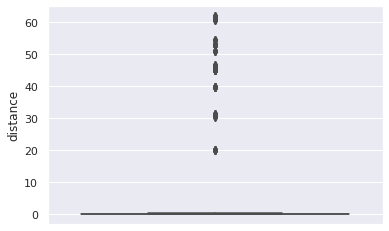

In [36]:
sns.boxplot(y=train['distance'])

In [37]:
que = "distance >= 2"
tra = train.query(que)
te = test.query(que)
tra
# 데이터를 확인해본 결과 Restaurant_latitude가 마이너스 형태로 잘못 처리되어있다. 이를 +로 바꿔주고 다시 계산하자

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken,day,weekday,distance,age_group,H1,H2,pickup_time
92,0xc042,AGRRES010DEL01,34,4.7,-27.163303,78.057044,27.233303,78.127044,Sandstorms,Low,1,Drinks,scooter,0,0,Metropolitian,15,2,0,54.396651,30s,22,23,5
283,0xc044,AGRRES12DEL03,32,4.7,-27.165108,78.015053,27.225108,78.075053,Sandstorms,Jam,2,Meal,scooter,1,0,Metropolitian,31,6,1,54.390249,30s,20,21,15
1091,0xc086,GOARES010DEL03,20,4.7,-15.546594,73.760431,15.606594,73.820431,Cloudy,Jam,2,Drinks,motorcycle,1,0,Metropolitian,29,6,1,31.153246,20s,19,20,10
1783,0xc067,BHPRES13DEL02,39,4.5,-23.230791,77.437020,23.250791,77.457020,Cloudy,Low,0,Meal,motorcycle,1,0,Metropolitian,29,6,1,46.481586,30s,9,9,5
1976,0xc061,KOLRES16DEL01,25,4.0,-22.539129,88.365507,22.549129,88.375507,Sandstorms,Low,0,Buffet,motorcycle,0,0,Metropolitian,19,1,0,45.088259,20s,9,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43860,0xc0b9,GOARES16DEL01,32,4.6,-15.498603,73.826911,15.568603,73.896911,Sandstorms,Low,0,Snack,motorcycle,1,0,Metropolitian,24,4,0,31.067285,30s,23,23,5
44051,0xc06d,GOARES14DEL03,22,5.0,-15.157944,73.950889,15.217944,74.010889,Sandstorms,Medium,1,Buffet,scooter,1,0,Metropolitian,27,3,0,30.375947,20s,18,18,5
44640,0xc094,KOCRES06DEL03,23,4.8,-9.982834,76.283268,10.072834,76.373268,Sunny,Jam,0,Drinks,motorcycle,1,0,Metropolitian,21,0,0,20.055870,20s,19,19,15
44933,0xc0c2,AURGRES03DEL03,30,4.9,-19.874733,75.353942,19.904733,75.383942,Fog,Low,1,Buffet,motorcycle,0,0,Metropolitian,15,1,0,39.779477,30s,22,22,15


In [38]:
train.loc[train['distance']> 2.0, 'distance'] = np.sqrt((tra['Delivery_location_latitude'] + tra['Restaurant_latitude'])**2 + 
                    (tra['Delivery_location_longitude'] - tra['Restaurant_longitude'])**2)

test.loc[test['distance']> 2.0, 'distance'] = np.sqrt((te['Delivery_location_latitude'] + te['Restaurant_latitude'])**2 + 
                    (te['Delivery_location_longitude'] - te['Restaurant_longitude'])**2)

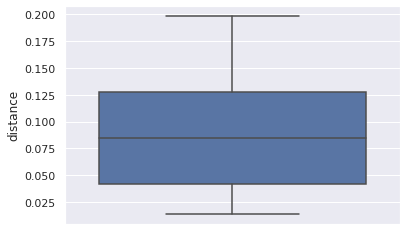

In [39]:
# 다시 분포 확인
sns.boxplot(y=train['distance']);
# 이상치가 처리되었다.

In [40]:
# 거리변수를 생성했으니 경도 위도 제거
train.drop('Delivery_location_latitude',axis =1, inplace=True)
test.drop('Delivery_location_latitude',axis =1, inplace=True)

train.drop('Restaurant_latitude',axis =1, inplace=True)
test.drop('Restaurant_latitude',axis =1, inplace=True)

train.drop('Delivery_location_longitude',axis =1, inplace=True)
test.drop('Delivery_location_longitude',axis =1, inplace=True)

train.drop('Restaurant_longitude',axis =1, inplace=True)
test.drop('Restaurant_longitude',axis =1, inplace=True)


In [41]:
train.describe()

,Delivery_person_Age,Delivery_person_Ratings,Vehicle_condition,multiple_deliveries,Festival,Time_taken,day,weekday,distance,H1,H2,pickup_time
count,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000
mean,29.610013,4.633209,0.995891,0.748139,0.020136,26.553350,2.929076,0.254158,0.090341,17.577669,17.762328,9.989243
std,5.764152,0.315861,0.817995,0.572934,0.140468,9.334363,1.972396,0.435392,0.051914,4.507409,4.521323,4.086094
min,20.000000,2.500000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.014141,8.000000,8.000000,5.000000
25%,25.000000,4.500000,0.000000,0.000000,0.000000,19.000000,1.000000,0.000000,0.042426,15.000000,16.000000,5.000000
50%,30.000000,4.700000,1.000000,1.000000,0.000000,26.000000,3.000000,0.000000,0.084853,19.000000,19.000000,10.000000
75%,35.000000,4.900000,2.000000,1.000000,0.000000,33.000000,5.000000,1.000000,0.127279,21.000000,21.000000,15.000000
max,39.000000,5.000000,2.000000,3.000000,1.000000,54.000000,6.000000,1.000000,0.197990,23.000000,24.000000,15.000000


### 분포

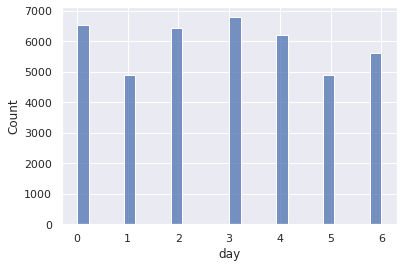

In [42]:
# 날짜별 이용행태 조사 day 컬럼 0~6 활용하기
# {0:월, 1:화, 2:수, 3:목, 4:금, 5:토, 6:일}
sns.histplot(data=train, x='day', ); # 오히려 주말에 적은 경향

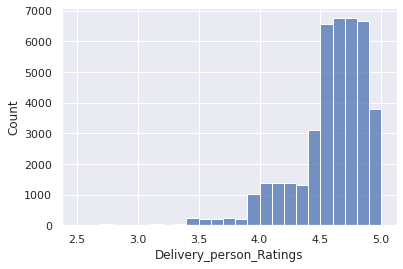

In [43]:
# 평점별 분포
sns.histplot(data=train, x='Delivery_person_Ratings', binwidth=0.1); 
# right skewed 되어있다. 이상치인 2.5- 3.3인 부분에 대해서 알아보자

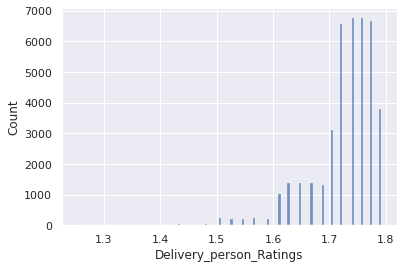

In [44]:
sns.histplot(np.log1p(train['Delivery_person_Ratings'])) # 로그변환해도 똑같다

In [45]:
que = "Delivery_person_Ratings >= 2.5 and Delivery_person_Ratings <= 3.3"
dpr_low = train.query(que)

In [46]:
dpr_low 
# 특이한 부분 
# 시간대가 늦은 시간이다.
# Road_traffic이 Low가 많다. -> 늦은시간이니 밀리지 않는 듯
# City가 거의 Metropolitian이다. -> 거의 직장인
# 대충 예상가는 시나리오 : 늦은시간 지친 몸을 이끌고 배달 주문을 한 상태 : 이미 지친 마음 짜증남 -> 평점에 반영됨
# 거기에 배달 시간까지 느리면 더 낮을 듯

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken,day,weekday,distance,age_group,H1,H2,pickup_time
389,0x8b39,VADRES01DEL01,24,2.6,Sunny,Low,1,Drinks,motorcycle,1,1,Metropolitian,42,5,1,0.155563,20s,22,22,15
575,0x5fd4,SURRES04DEL01,23,2.5,Sunny,Low,1,Buffet,motorcycle,1,0,Metropolitian,34,6,1,0.155563,20s,23,24,15
934,0xc714,BHPRES14DEL03,29,2.5,Sunny,Low,2,Drinks,scooter,1,1,Metropolitian,41,4,0,0.127279,20s,22,23,10
1333,0x2daf,HYDRES05DEL02,20,2.5,Sunny,Low,1,Snack,scooter,1,0,Metropolitian,43,4,0,0.183848,20s,23,24,15
1391,0xe247,LUDHRES20DEL01,23,2.6,Sunny,Low,1,Drinks,scooter,1,0,Metropolitian,43,4,0,0.155563,20s,23,23,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44488,0xd6b0,DEHRES12DEL02,21,2.6,Sunny,Low,2,Snack,motorcycle,1,0,Metropolitian,34,2,0,0.113137,20s,23,23,5
44623,0x71fd,SURRES20DEL01,28,2.7,Sunny,Low,1,Meal,scooter,1,0,Metropolitian,35,6,1,0.155563,20s,22,22,10
44734,0xb12b,MYSRES06DEL02,36,3.3,Sunny,Low,0,Meal,motorcycle,2,0,Metropolitian,34,6,1,0.113137,30s,22,22,5
45300,0x6c66,JAPRES12DEL03,22,2.9,Sunny,Low,2,Drinks,scooter,1,0,Metropolitian,33,4,0,0.127279,20s,22,22,10


In [47]:
# 순서형 변수 분포 확인 
# 배달원의 나이
arr = train[cols_num[0]].unique()
arr.sort()
print(arr)
print("배달원 나이 : ", train[cols_num[0]].nunique())
# 20~ 39세의 데이터이며 10대이하, 40대이상이 데이터가 존재하지 않는다.
# 안전상...? 그런조건은 존재하지 않음

[20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
배달원 나이 :  20


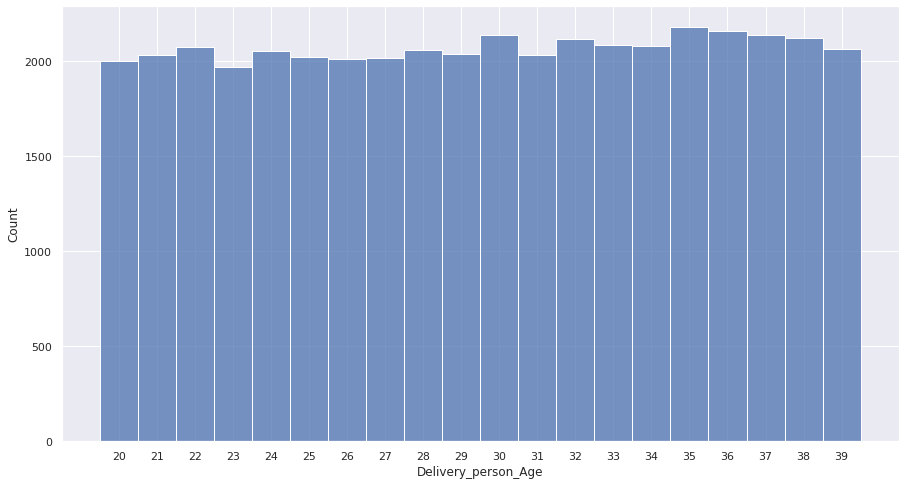

In [48]:
# 배달원의 나이 분포
# https://www.yna.co.kr/view/AKR20220302150600002
plt.figure(figsize=(15,8)) # 먼저 크기를 지정한다음 그래프 그리기
sns.histplot(data=train, x=cols_num[0], discrete=True); # 나이는 이산형 데이터이기 때문에 discrete설정
plt.xticks(ticks=range(20,40,1))
plt.show(); # 거의 균등분포임 -> 특이한 부분을 찾을 수 없음

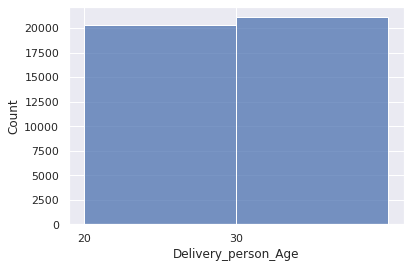

In [49]:
# 연령대별 분포
sns.histplot(data=train, x=cols_num[0], binwidth=10); 
plt.xticks(ticks=range(20,40,10))
plt.show(); # 미세한 차이로 30대가 더 많다
# 별 내용은 없는듯...

In [50]:
train.groupby(cols_num[0]).agg({'Time_taken': "mean"}).sort_values(by=['Time_taken'],ascending=[False]).round(2)
# 연령별 시간을 확인해보니 최대 최소 7분 가량의 평균 차이가 존재함

,Time_taken
Delivery_person_Age,
32,30.02
39,29.85
31,29.77
35,29.73
36,29.69
34,29.69
33,29.68
38,29.61
37,29.45


In [51]:
train.groupby('age_group').agg({'Time_taken': "mean"}).sort_values(by=['Time_taken'],ascending=[False]).round(2)
# 연령대에 따라 6분정도 차이가 존재함
# 30대는 거의 다 직장인이니까 몰리는 시간(퇴근시간)에 일하기
# 20대는 대학생이니까 시간대에 거의 구애받지 않는 듯
# 가설 : 30대는 피크타임에 많이 활동한다

,Time_taken
age_group,
30s,29.68
20s,23.30


In [53]:
# 순서형 변수 분포 확인 
# 동시에 배달, 혹은 배달 순서
train[cols_num[1]].unique()
# 이 칼럼의 경우 경우의 수가 적기때문에 histplot이 아닌 countplot으로 분포를 확인

array([0, 1, 3, 2])

,Time_taken
multiple_deliveries,
3,47.83
2,40.47
1,26.99
0,23.11


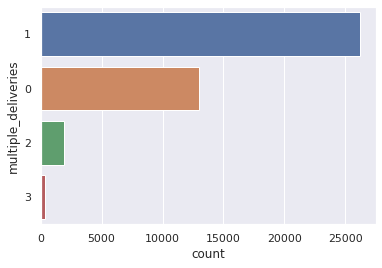

In [54]:
target_mean(train, cols_num[1],'Time_taken')
# 근데 0번째 배달은 뭐지..? -> 0번째로 가져다 준 배달 3번째로 가져다준 배달인듯


In [55]:
# 3가지를 배달하는데도 빠른 데이터는 어떤 인사이트를 얻을 수 있는지 확인
que = "multiple_deliveries == 3"
sam=train.query(que)
sam['Delivery_person_ID'].nunique()

284

In [56]:
sam
# 확실히 3번째니까 더 오래걸리는군...
# 이 해석은 PDP 이용하면 되니까 냅둬

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken,day,weekday,distance,age_group,H1,H2,pickup_time
9,0xcdcd,DEHRES17DEL01,36,4.2,Fog,Jam,2,Snack,motorcycle,3,0,Metropolitian,46,4,0,0.098995,30s,21,22,15
43,0xb796,SURRES17DEL03,37,4.7,Sandstorms,Jam,0,Snack,motorcycle,3,0,Metropolitian,52,0,0,0.127279,30s,19,19,5
159,0x87e4,VADRES13DEL03,36,4.0,Sunny,Jam,0,Meal,motorcycle,3,0,Metropolitian,44,2,0,0.127279,30s,20,20,5
165,0x5631,HYDRES18DEL03,35,4.8,Fog,Medium,0,Meal,motorcycle,3,0,Metropolitian,48,6,1,0.127279,30s,17,17,10
182,0x290c,MYSRES18DEL01,35,4.9,Fog,Jam,0,Drinks,motorcycle,3,0,Metropolitian,43,3,0,0.098995,30s,21,21,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44676,0x52ef,CHENRES11DEL02,32,4.9,Stormy,Jam,0,Drinks,motorcycle,3,0,Urban,44,0,0,0.070711,30s,21,21,10
45051,0x57cb,BANGRES12DEL01,26,4.4,Cloudy,Jam,1,Snack,motorcycle,3,0,Metropolitian,42,2,0,0.098995,20s,19,19,10
45207,0x5ff8,MYSRES03DEL03,39,4.1,Sandstorms,Jam,0,Drinks,motorcycle,3,0,Metropolitian,51,2,0,0.127279,30s,20,21,10
45398,0x9193,PUNERES03DEL01,37,4.9,Cloudy,Medium,2,Buffet,scooter,3,0,Metropolitian,43,2,0,0.098995,30s,17,17,10


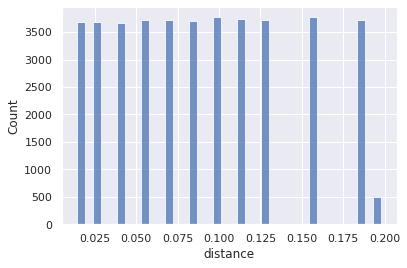

In [57]:
# 거리 분포 확인
sns.histplot(data=train, x='distance');

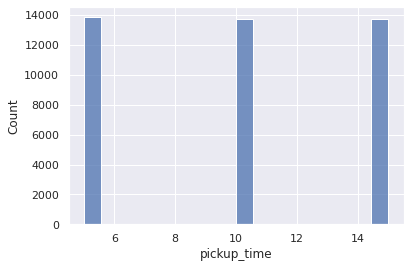

In [58]:
# 픽업 시간 확인
sns.histplot(data=train, x='pickup_time');

In [59]:
train['pickup_time'].unique()

array([15,  5, 10])

In [60]:
# 치우친 데이터 확인
from scipy.stats import skew
numeric_feats = train.dtypes[train.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10) # Festival과 weekday는 범주형 이기 때문에 치우친 데이터는 없다.


Skew in numerical features: 



,Skew
Festival,6.832424
weekday,1.129305
Time_taken,0.476699
multiple_deliveries,0.324420
distance,0.322384
day,0.030536
Vehicle_condition,0.007563
pickup_time,0.003956
Delivery_person_Age,-0.029449
H2,-0.798803


## 범주형

,Time_taken
Weather,
Fog,29.17
Cloudy,29.14
Windy,26.36
Sandstorms,26.11
Stormy,26.11
Sunny,22.14


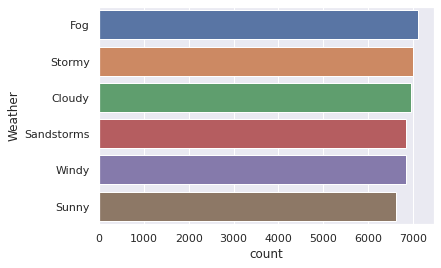

In [61]:
target_mean(train,cols_cat[0],'Time_taken')
# Stormy 즉 폭풍우치는 날이 왜 배달 빨리됐지?
# 사람들이 눈치껏 가까운 곳에서만 주문한건가?
# 가설 Stormy 고객데이터는 아닌 고객데이터에 비해 가까운 거리에서 주문한다.

In [62]:
que = "Weather == 'Stormy'"
df_st = train.query(que)
df_st['distance'].mean()

0.09001893042865679

In [63]:
que = "Weather != 'Stormy'"
df_nst = train.query(que)
df_nst['distance'].mean()

0.09040664209573113

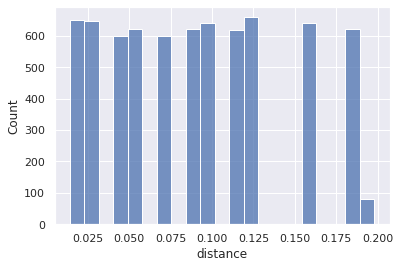

In [64]:
sns.histplot(df_st['distance']);

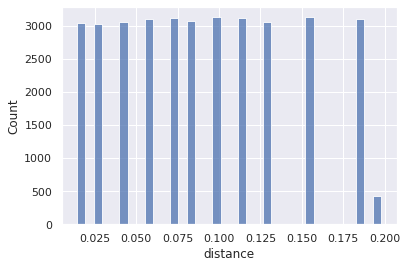

In [65]:
sns.histplot(df_nst['distance']); # 별차이가 없다... 
# 가설 기각함

,Time_taken
Road_traffic_density,
Jam,31.40
High,27.41
Medium,26.90
Low,21.49


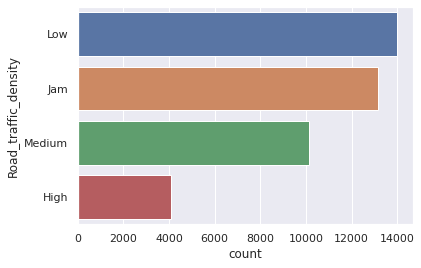

In [66]:
target_mean(train,cols_cat[1],'Time_taken')
# 가설 : 교통상황이 혼잡할수록 배달시간이 오래걸린다.
# 가설 채택
# 교통상황에 따라 시간이 지연된다. -> 순서형 범주 가능

,Time_taken
Type_of_order,
Meal,26.67
Buffet,26.54
Snack,26.54
Drinks,26.46


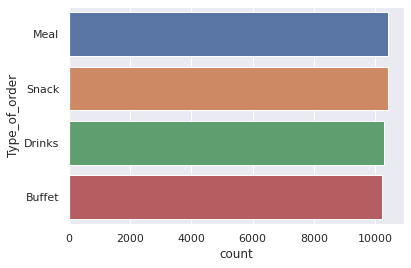

In [67]:
target_mean(train,cols_cat[2],'Time_taken')
# 가설 : 음식 종류에 따라 배달시간에 차이를 보인다.
# 다 비슷함 -> 음식 종류에 따라서는 별 다른 차이를 보이지 않는다.
# 가설 기각

,Time_taken
Type_of_vehicle,
motorcycle,27.84
scooter,24.75
electric_scooter,24.59


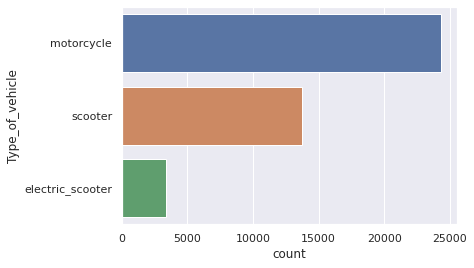

In [68]:
target_mean(train,cols_cat[3],'Time_taken')

'\nSemi-Urban : 준도시\nMetropolitian\t: 대도시\nUrban : 도시\n준도시의 경우 교통체계가 잘 잡혀있지 않아 시간이 오래걸리는 것 같고\n대도시의 경우 교통체계는 좋지만 교통상황때문에 도시에 비해 오래걸리는 것 같다.\n'

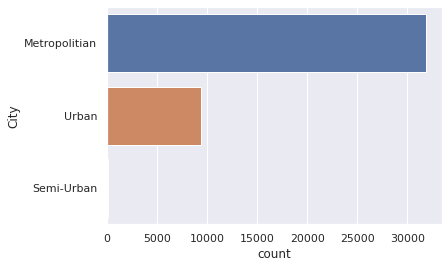

In [69]:
target_mean(train,cols_cat[4],'Time_taken')
'''
Semi-Urban : 준도시
Metropolitian	: 대도시
Urban : 도시
준도시의 경우 교통체계가 잘 잡혀있지 않아 시간이 오래걸리는 것 같고
대도시의 경우 교통체계는 좋지만 교통상황때문에 도시에 비해 오래걸리는 것 같다.
'''

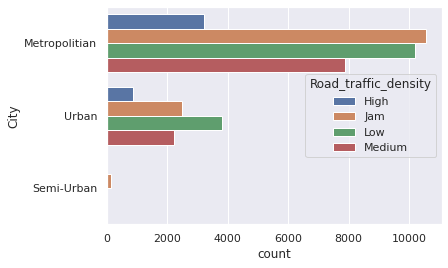

In [70]:
# 가설 : 대도시는 도시보다 jam인 상황이 더 많을 것이다.
sns.countplot(data=train, y=cols_cat[4], order = train[cols_cat[4]].value_counts().index, hue = 'Road_traffic_density')
# 가설 채택 : 확실히 대도시가 jam인 상황이 더 많다.

,Time_taken
Festival,
1,45.52
0,26.16


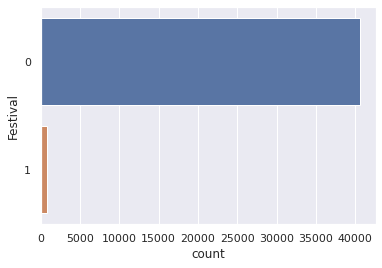

In [71]:
target_mean(train,'Festival','Time_taken')
# 페스티벌을 하면 사람들이 밀집되기 때문에 배달 지연됨

,Time_taken
Vehicle_condition,
0,30.24
2,24.73
1,24.64


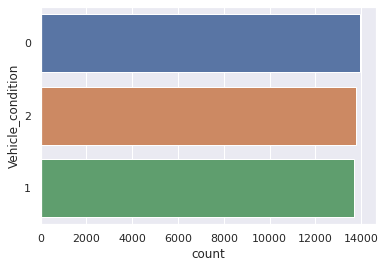

In [72]:
target_mean(train,'Vehicle_condition','Time_taken')

In [73]:
'''
Vehicle_condition 은 아마존 내에서 상품을 배송하는 차량의 조건이다.
https://sellercentral.amazon.com/help/hub/reference/external/200978420?locale=ko-KR
숫자에 따른 정확한 조건은 아마존 사에서 내부적으로 처리하는 것이기 때문에 자세한 사항은 알지 못한다.
값이 높거나 낮을수록 타겟값에 영향이 있는 것이 아니기 때문에 명목형 범주형으로 놔두어야 한다.
'''

'\nVehicle_condition 은 아마존 내에서 상품을 배송하는 차량의 조건이다.\nhttps://sellercentral.amazon.com/help/hub/reference/external/200978420?locale=ko-KR\n숫자에 따른 정확한 조건은 아마존 사에서 내부적으로 처리하는 것이기 때문에 자세한 사항은 알지 못한다.\n값이 높거나 낮을수록 타겟값에 영향이 있는 것이 아니기 때문에 명목형 범주형으로 놔두어야 한다.\n'

,Time_taken
H1,
20,31.41
19,31.41
21,31.37
13,27.69
17,27.63
18,27.47
14,27.46
11,27.41
12,27.07


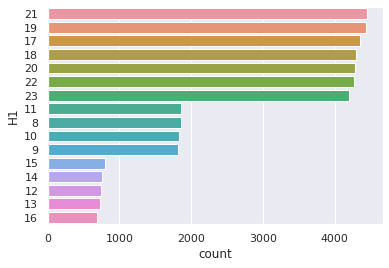

In [74]:
target_mean(train,'H1','Time_taken')
# 시간대별로 주문량이 달라지는 것이 확연히 보임
# 더불어 시간대별로 시간도 오래걸림
# 이것을 기준으로 순서형 범주형으로 변환할 수 있다.

,Time_taken
weekday,
0,26.68
1,26.19


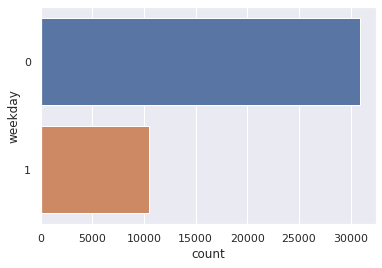

In [75]:
# 평일 주말 확인
target_mean(train,'weekday','Time_taken') # 별다른 차이는 없다

## 타겟

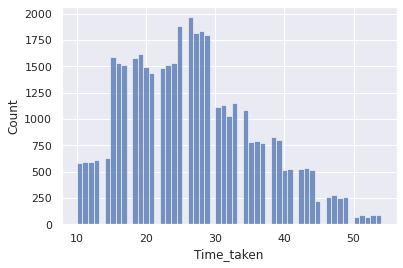

In [76]:
# 타겟의 분포 확인
sns.histplot(data=train, x ="Time_taken"); # right skewed 데이터임
# 로그변환을 하자

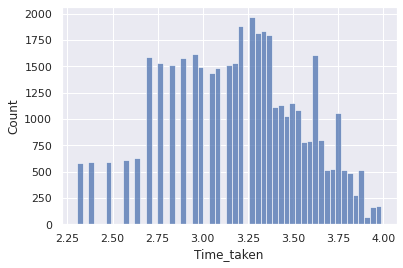

In [77]:
tar = train['Time_taken']
sns.histplot(np.log(tar));
# 로그변환을 하니 분포가 정규분포형태로 유사해짐

In [78]:
# 또는 TransformedTargetRegrssor사용

## 상관관계

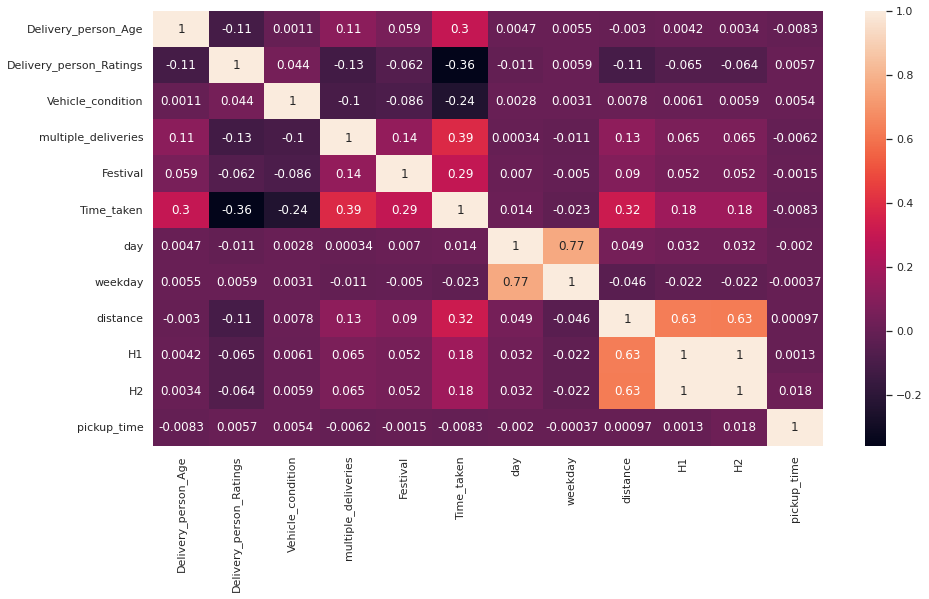

In [79]:
# 상관관계 파악
# 상관관계가 높은 변수 2개 해서 sns 그래프 hue 사용하면 좋을듯
# https://github.com/raminicano/ds-section2-sprint3/blob/main/n233-ml-problem-framing/n233-ml-problem-framing.ipynb
plt.figure(figsize=(15,8))
corr = train.corr()  # 자동으로 수치형 데이터 간의 correlation coefficient를 계산해 줍니다.
sns.heatmap(corr, annot=True)
plt.show();

## 범주형 데이터 변환

In [80]:
train['Road_traffic_density']=train['Road_traffic_density'].replace({'Jam':4, 'High':3, 'Medium':2,'Low':1})
train['Weather']=train['Weather'].replace({'Sunny':1, 'Stormy':2, 'Sandstorms':2,'Windy':3,'Fog':4,'Cloudy':5})
train['City']=train['City'].replace({'Metropolitian':1, 'Urban':2, 'Semi-Urban':3})


In [81]:
test['Road_traffic_density']=test['Road_traffic_density'].replace({'Jam':4, 'High':3, 'Medium':2,'Low':1})
test['Weather']=test['Weather'].replace({'Sunny':1, 'Stormy':2, 'Sandstorms':2,'Windy':3,'Fog':4,'Cloudy':5})
test['City']=test['City'].replace({'Metropolitian':1, 'Urban':2, 'Semi-Urban':3})

In [82]:
train['Peak_time']=train['H2'].replace({8:1,9:1,10:1,
                                       11:2,12:3,13:3,14:3,
                                       15:2,16:2,17:3,18:3,
                                       19:4,20:4,21:4,
                                       22:2,23:2,24:2})

test['Peak_time']=test['H2'].replace({8:1,9:1,10:1,
                                       11:2,12:3,13:3,14:3,
                                       15:2,16:2,17:3,18:3,
                                       19:4,20:4,21:4,
                                       22:2,23:2,24:2})

In [83]:
# 전처리 완료
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41368 entries, 0 to 45592
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       41368 non-null  object 
 1   Delivery_person_ID       41368 non-null  object 
 2   Delivery_person_Age      41368 non-null  int64  
 3   Delivery_person_Ratings  41368 non-null  float64
 4   Weather                  41368 non-null  int64  
 5   Road_traffic_density     41368 non-null  int64  
 6   Vehicle_condition        41368 non-null  int64  
 7   Type_of_order            41368 non-null  object 
 8   Type_of_vehicle          41368 non-null  object 
 9   multiple_deliveries      41368 non-null  int64  
 10  Festival                 41368 non-null  int64  
 11  City                     41368 non-null  int64  
 12  Time_taken               41368 non-null  int64  
 13  day                      41368 non-null  int64  
 14  weekday               

In [84]:
train.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken,day,weekday,distance,age_group,H1,H2,pickup_time,Peak_time
0,0x4607,INDORES13DEL02,37,4.9,1,3,2,Snack,motorcycle,0,0,2,24,5,1,0.028284,30s,11,11,15,2
1,0xb379,BANGRES18DEL02,34,4.5,2,4,2,Snack,scooter,1,0,1,33,4,0,0.183848,30s,19,19,5,4
2,0x5d6d,BANGRES19DEL01,23,4.4,2,1,0,Drinks,motorcycle,1,0,2,26,5,1,0.014142,20s,8,8,15,1
3,0x7a6a,COIMBRES13DEL02,38,4.7,1,2,0,Buffet,motorcycle,1,0,1,21,2,0,0.070711,30s,17,18,10,3
4,0x70a2,CHENRES12DEL01,32,4.6,5,3,1,Snack,scooter,1,0,1,30,5,1,0.056569,30s,13,13,15,3


In [85]:
train.groupby(['age_group','Peak_time']).agg({'Time_taken': "mean"}).sort_values(by=['Time_taken'],ascending=[False]).round(2)

Time_taken
age_group Peak_time            
30s       4               34.96
          3               30.51
20s       4               27.30
30s       2               26.57
20s       3               24.33
30s       1               22.35
20s       2               20.78
          1               17.02

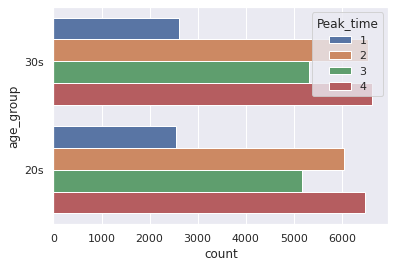

In [86]:
# 가설 : 30대는 피크타임에 많이 활동한다
sns.countplot(data=train, y='age_group', order = train['age_group'].value_counts().index, hue = 'Peak_time')
# 가설 기각 별 차이 없음

# Modeling

In [88]:
# 필요없는 열 드롭
train.drop(['ID', 'Delivery_person_ID'],axis =1, inplace=True)
test.drop(['ID', 'Delivery_person_ID'],axis =1, inplace=True)

In [89]:
# 더미변수 생성
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [90]:
X,y = train.drop(["Time_taken"],axis=1),train["Time_taken"]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 42)

In [91]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33094, 24), (8274, 24), (33094,), (8274,))

In [92]:
# baseline 모델, 평균사용
baseline = [y_train.mean()] * len(y_train)
baseline_r2 = r2_score(y_train, baseline)
base_rmse =  mean_squared_log_error(y_train, baseline)**0.5
print(f'기준모델의 r2_score: {baseline_r2}')
print(f'기준모델의 rmlse : {base_rmse}')

기준모델의 r2_score: 0.0
기준모델의 rmlse : 0.3550510661626483


In [93]:
# 회귀에 따른 평가지표 통일

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmsle= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_log_error", cv = kf))
    return(rmsle)

In [ ]:
# 라쏘
from sklearn.linear_model import LassoCV

# lassocv로 학습
# alpha = np.arange(0.001, 100, 0.5), 알파를 조정해가며 파라미터를 조정해보려고 했으나 뭔가 계속 오류가 발생함 
# 자꾸 런타임이 종료되었다. 로컬로 연결해서 하면 좋겠지만 시간이 없어서 코랩으로 밖에 하지 못함
# ridgeCV도 마찬가지로 런타임 강제종료 에러...
lasso = LassoCV(alphas=alpha, cv=3, random_state=42)

lasso.fit(X_train, y_train)

print("alpha: ", lasso.alpha_)

# 성능 확인
rmsle_cv(lasso)

alpha:  0.001


5.919421520947401

In [94]:
# 여러가지 방법을 사용한 회귀
lasso = make_pipeline(StandardScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(StandardScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, 
                                   loss='huber', random_state =42)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =42, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.7f} ({:.7f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.7f} ({:.7f})\n".format(score.mean(), score.std()))


Lasso score: 0.2370098 (0.0017764)

ElasticNet score: 0.2370093 (0.0017764)



In [ ]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.7f} ({:.7f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.7f} ({:.7f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.7f} ({:.7f})\n" .format(score.mean(), score.std()))

Gradient Boosting score: 0.1589703 (0.0022870)

Xgboost score: 0.1656743 (0.0022001)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11

In [ ]:
# 교차검증을 통한 모델의 일반화 성능 검증
from scipy.stats.distributions import uniform

params = [{
  'n_estimator' : range(1000, 5000, 1000),
  'max_depth' : range(3,6),
  'learing_rate' : np.linspace(0.005, 0.1, 20)
}]

In [ ]:
gb = GradientBoostingRegressor(random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=params,
    scoring="neg_mean_squared_log_error",
    n_iter=10,
    cv=3,
    verbose=3,
    random_state=42,
)
randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


ValueError: ignored

## Automl

In [ ]:
pip install flaml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from flaml import AutoML
automl = AutoML()
# rmsle
automl.fit(X_train, y_train, task="regression",metric='rmse',time_budget=900, n_splits=5,verbose=False, estimator_list = ['lgbm','xgboost'])

In [ ]:
print('Best ML model:', automl.model)
print('Best hyperparameter config:', automl.best_config)
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML model: <flaml.model.XGBoostSklearnEstimator object at 0x7fd50957c590>
Best hyperparameter config: {'n_estimators': 53, 'max_leaves': 96, 'min_child_weight': 21.454057685185717, 'learning_rate': 0.13103696812010043, 'subsample': 0.8208696682481732, 'colsample_bylevel': 0.7870310378519725, 'colsample_bytree': 0.8432846585504319, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.2058408159551338}
Training duration of best run: 1.148 s


In [ ]:
score = rmsle_cv(automl.model)
print("automl score: {:.7f} ({:.7f})\n".format(score.mean(), score.std()))

automl score: 0.1505068 (0.0019362)



In [ ]:
automl.model.score(X_train, y_train)

0.8657911625189291

In [ ]:
automl.model.score(X_test, y_test)

0.8438131917517044

## 하이퍼파라미터 튜닝

In [108]:
from scipy.stats.distributions import uniform

pipe = make_pipeline(
      XGBRegressor(
        #eval_metric="rmsle",
        n_estimators=50,
        random_state=42,
        max_leaves= 96,
        min_child_weight=21,
        n_jobs=-1,
        learning_rate=0.13,
        subsample=0.82,
        colsample_bylevel=0.787,
        colsample_bytree=0.843,
        reg_lambda=0.2058,
        reg_alpha=0.00098,
        use_label_encoder=False,))

params = {
    "xgbregressor__min_child_weight": [25, 30, 35],
    "xgbregressor__colsample_bytree": uniform(loc=0.7, scale=0.2),
    "xgbregressor__learning_rate": uniform(loc=0.13, scale=0.1),
}

from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    scoring='neg_mean_squared_log_error',
    n_iter=10,
    cv=3,
    verbose=3,
    random_state=42,
)
randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[04:30:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/3] END xgbregressor__colsample_bytree=0.7749080237694724, xgbregressor__learning_rate=0.2250714306409916, xgbregressor__min_child_weight=35;, score=-0.029 total time=   1.3s
[04:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/3] END xgbregressor__colsample_bytree=0.7749080237694724, xgbregressor__learning_rate=0.2250714306409916, xgbregressor__min_child_weight=35;, score=-0.031 total time=   3.4s
[04:31:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/3] END xgbregressor__colsample_bytree=0.7749080237694724, xgbregressor__learning_rate=0.2250714306409916, xgbregressor__min_child_weight=35;, score=-0.030 total time=   0.7s
[04:31:03] WARNING

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('xgbregressor',
                                              XGBRegressor(colsample_bylevel=0.787,
                                                           colsample_bytree=0.843,
                                                           learning_rate=0.13,
                                                           max_leaves=96,
                                                           min_child_weight=21,
                                                           n_estimators=50,
                                                           n_jobs=-1,
                                                           random_state=42,
                                                           reg_alpha=0.00098,
                                                           reg_lambda=0.2058,
                                                           subsample=0.82,
                                                           u

In [109]:
print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 rmsle: ", np.sqrt(-randomized_search.best_score_))

최적 하이퍼파라미터:  {'xgbregressor__colsample_bytree': 0.8202230023486418, 'xgbregressor__learning_rate': 0.20080725777960456, 'xgbregressor__min_child_weight': 30}
최적 rmsle:  0.17393857921954375


In [ ]:
# 여러번 하이퍼파라미터를 넣어서 돌려봤지만 automl 모델보다 나아지질 않는다. 역시 인간은 한계가 있구나

# ML 해석

In [ ]:
plt.rcParams["figure.dpi"] = 144
# pdp 확인하는 함수
def pdp_check(target):
  isolated = pdp_isolate(
      model=automl.model,
      dataset=X_test,
      model_features=X_test.columns,
      feature=target,
      grid_type="percentile", 
      num_grid_points=10, 
    )
  pdp_plot(isolated, feature_name=target);

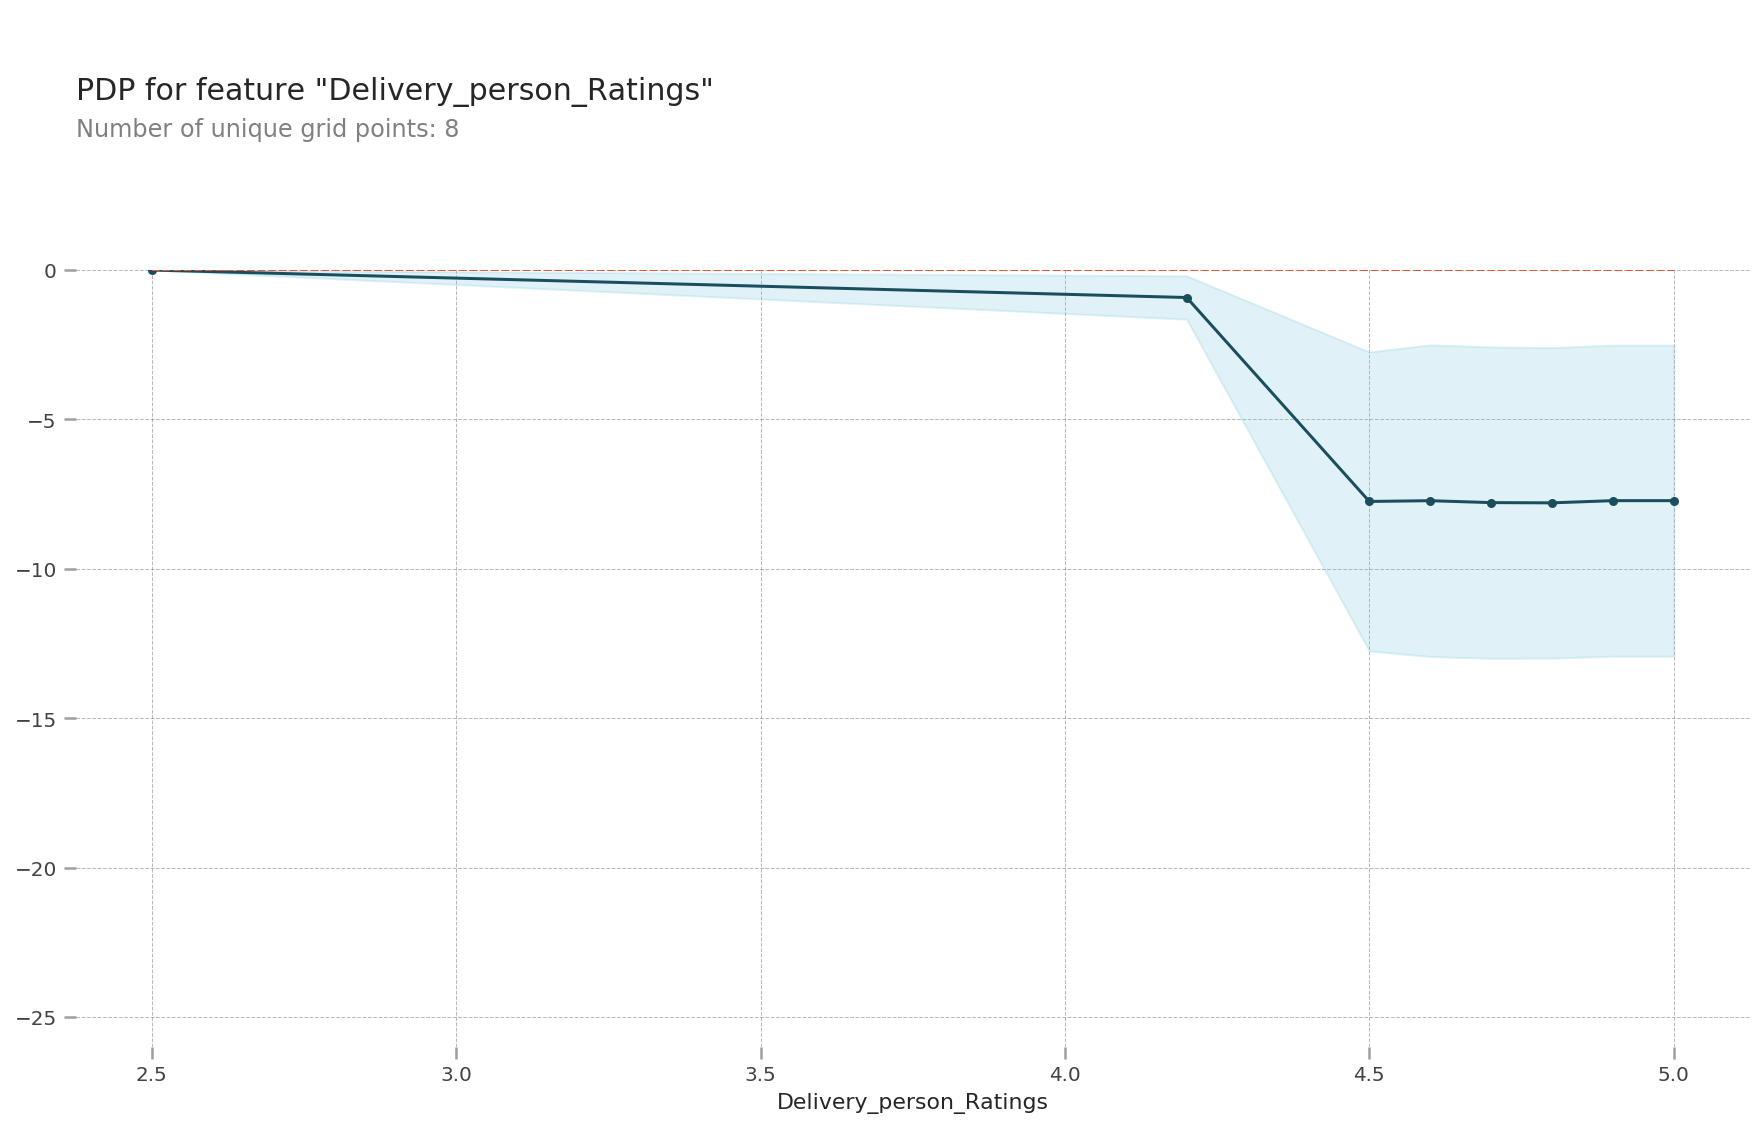

In [ ]:
pdp_check('Delivery_person_Ratings')

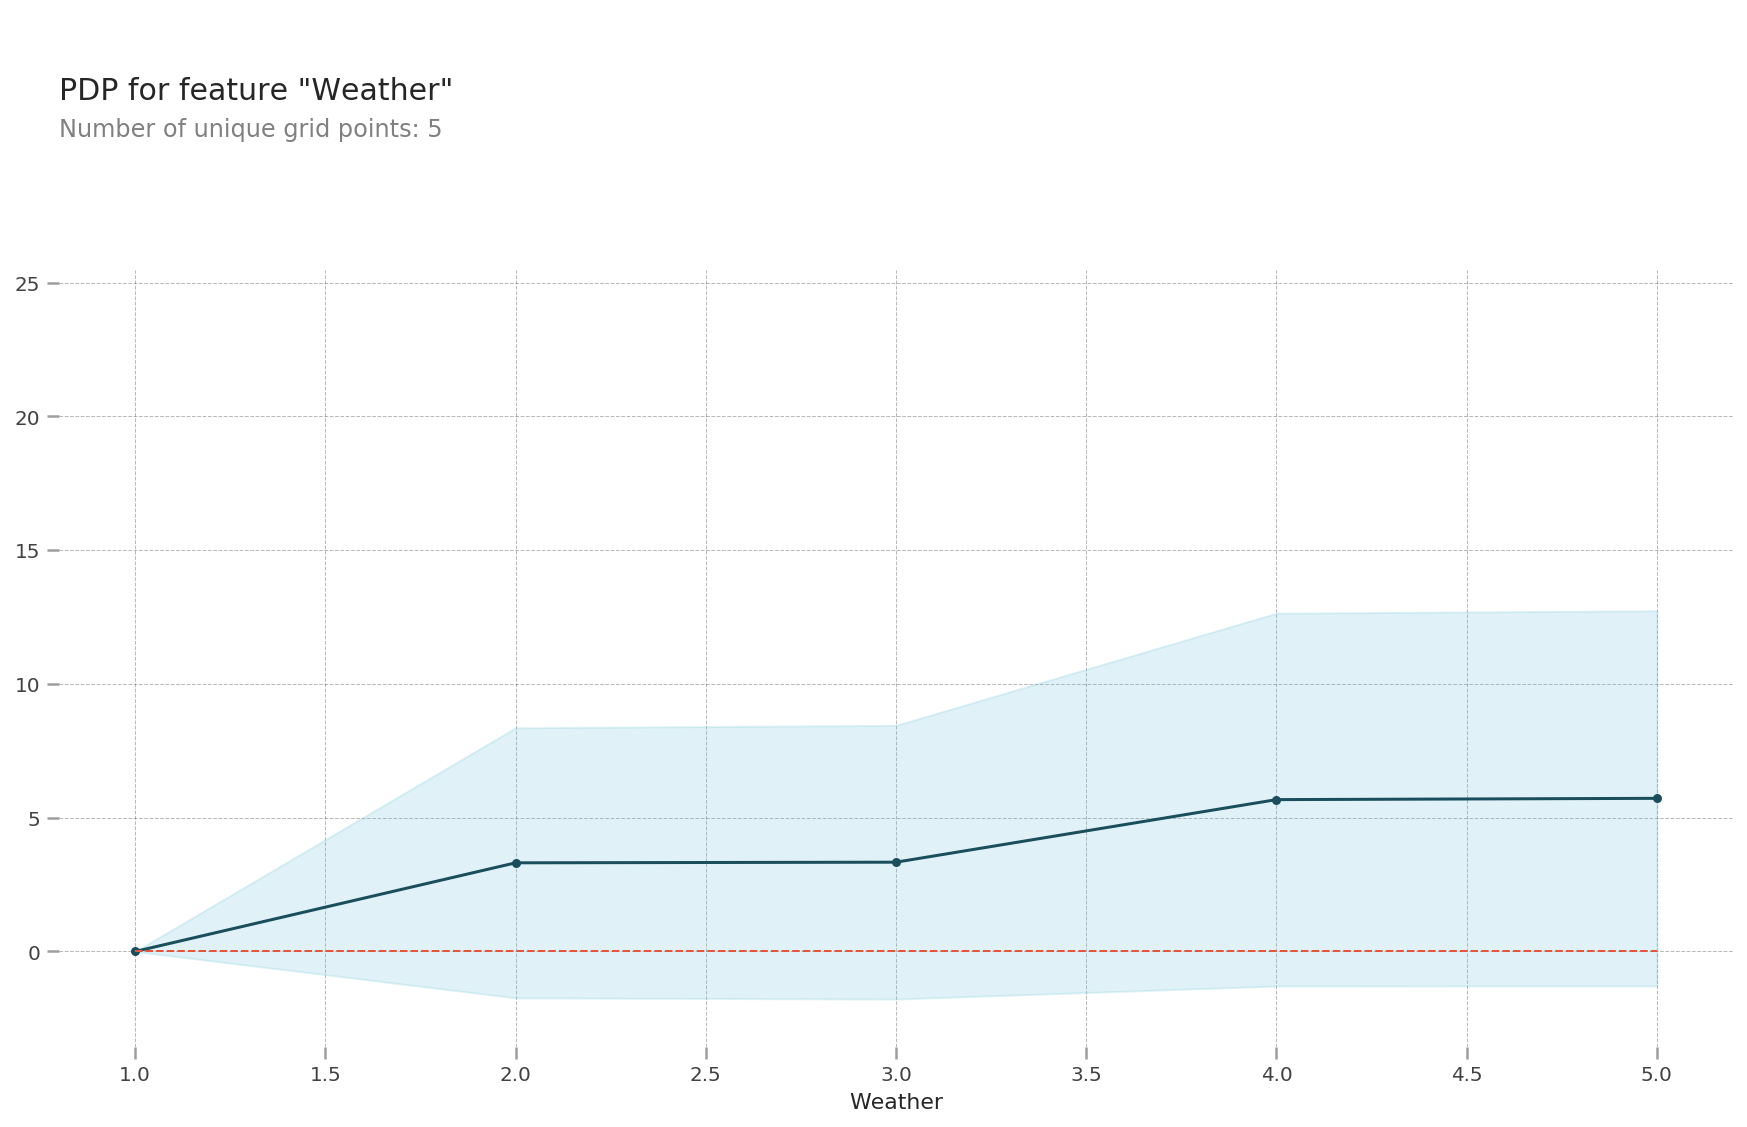

In [ ]:
pdp_check('Weather')

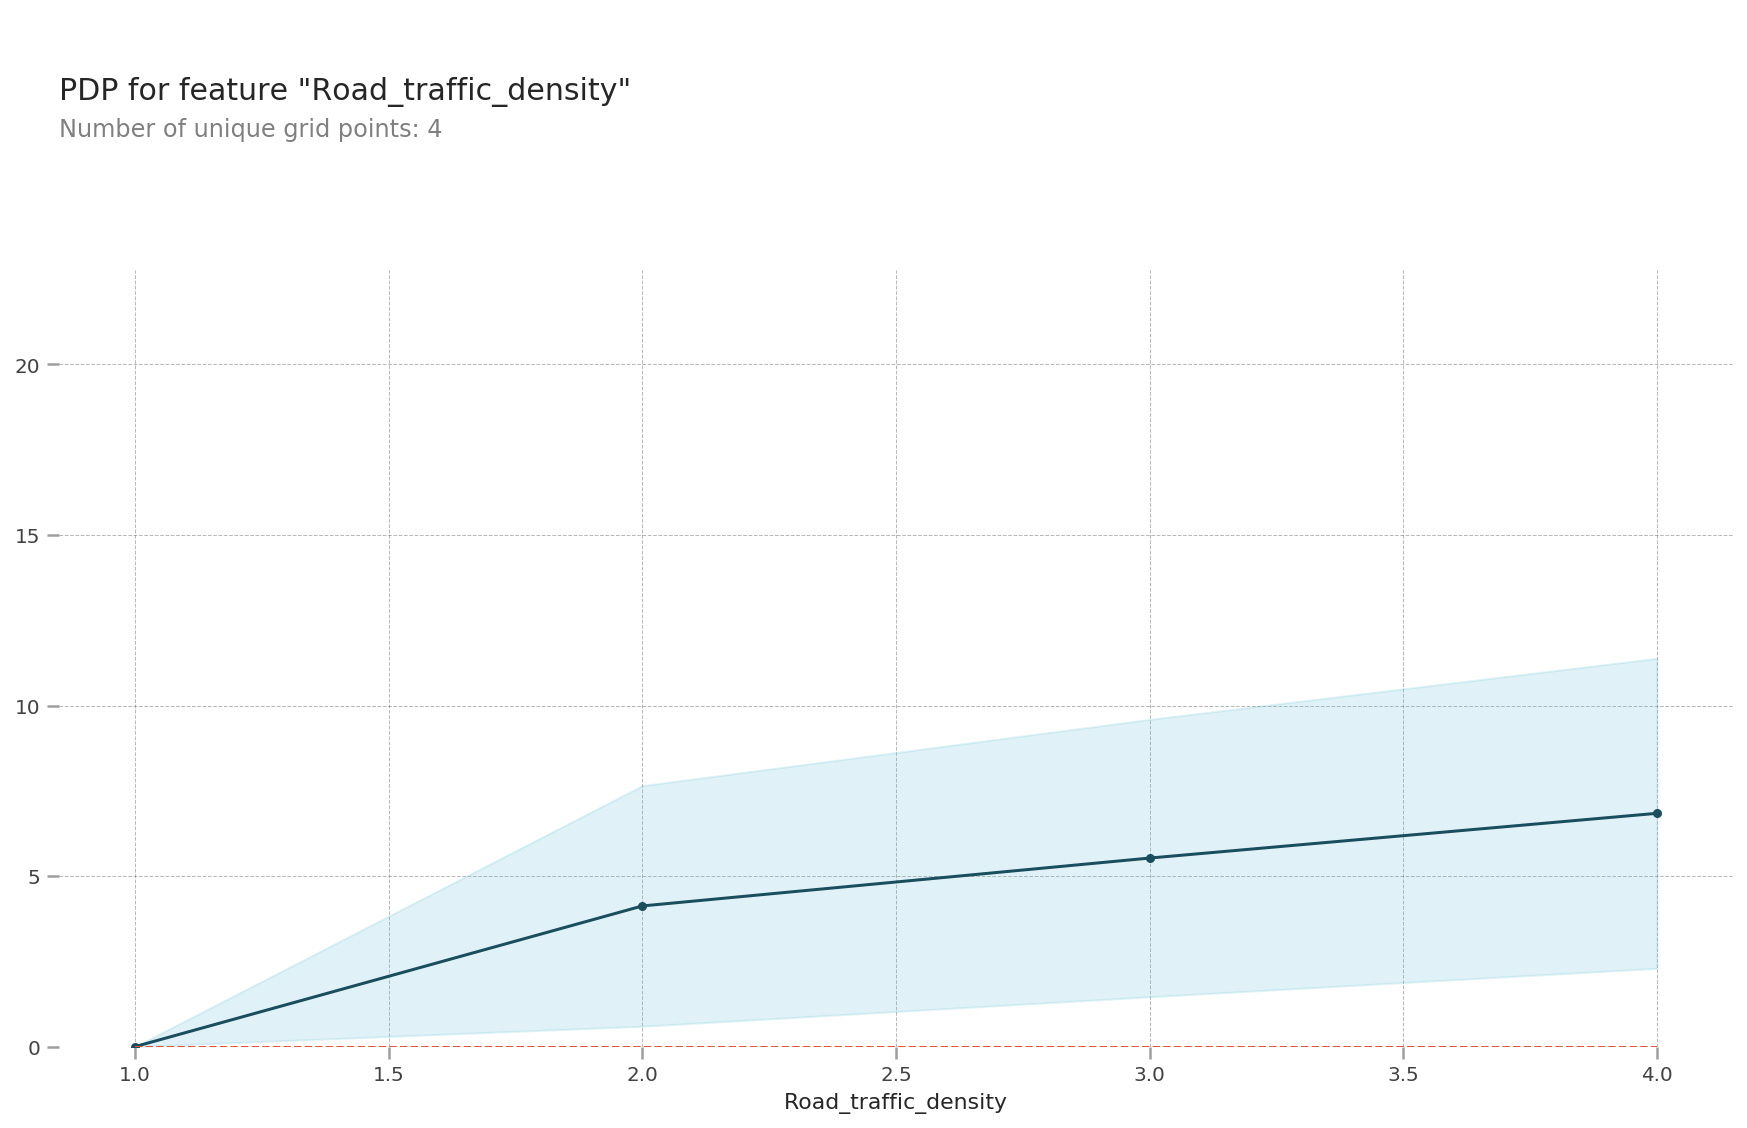

In [ ]:
pdp_check('Road_traffic_density')

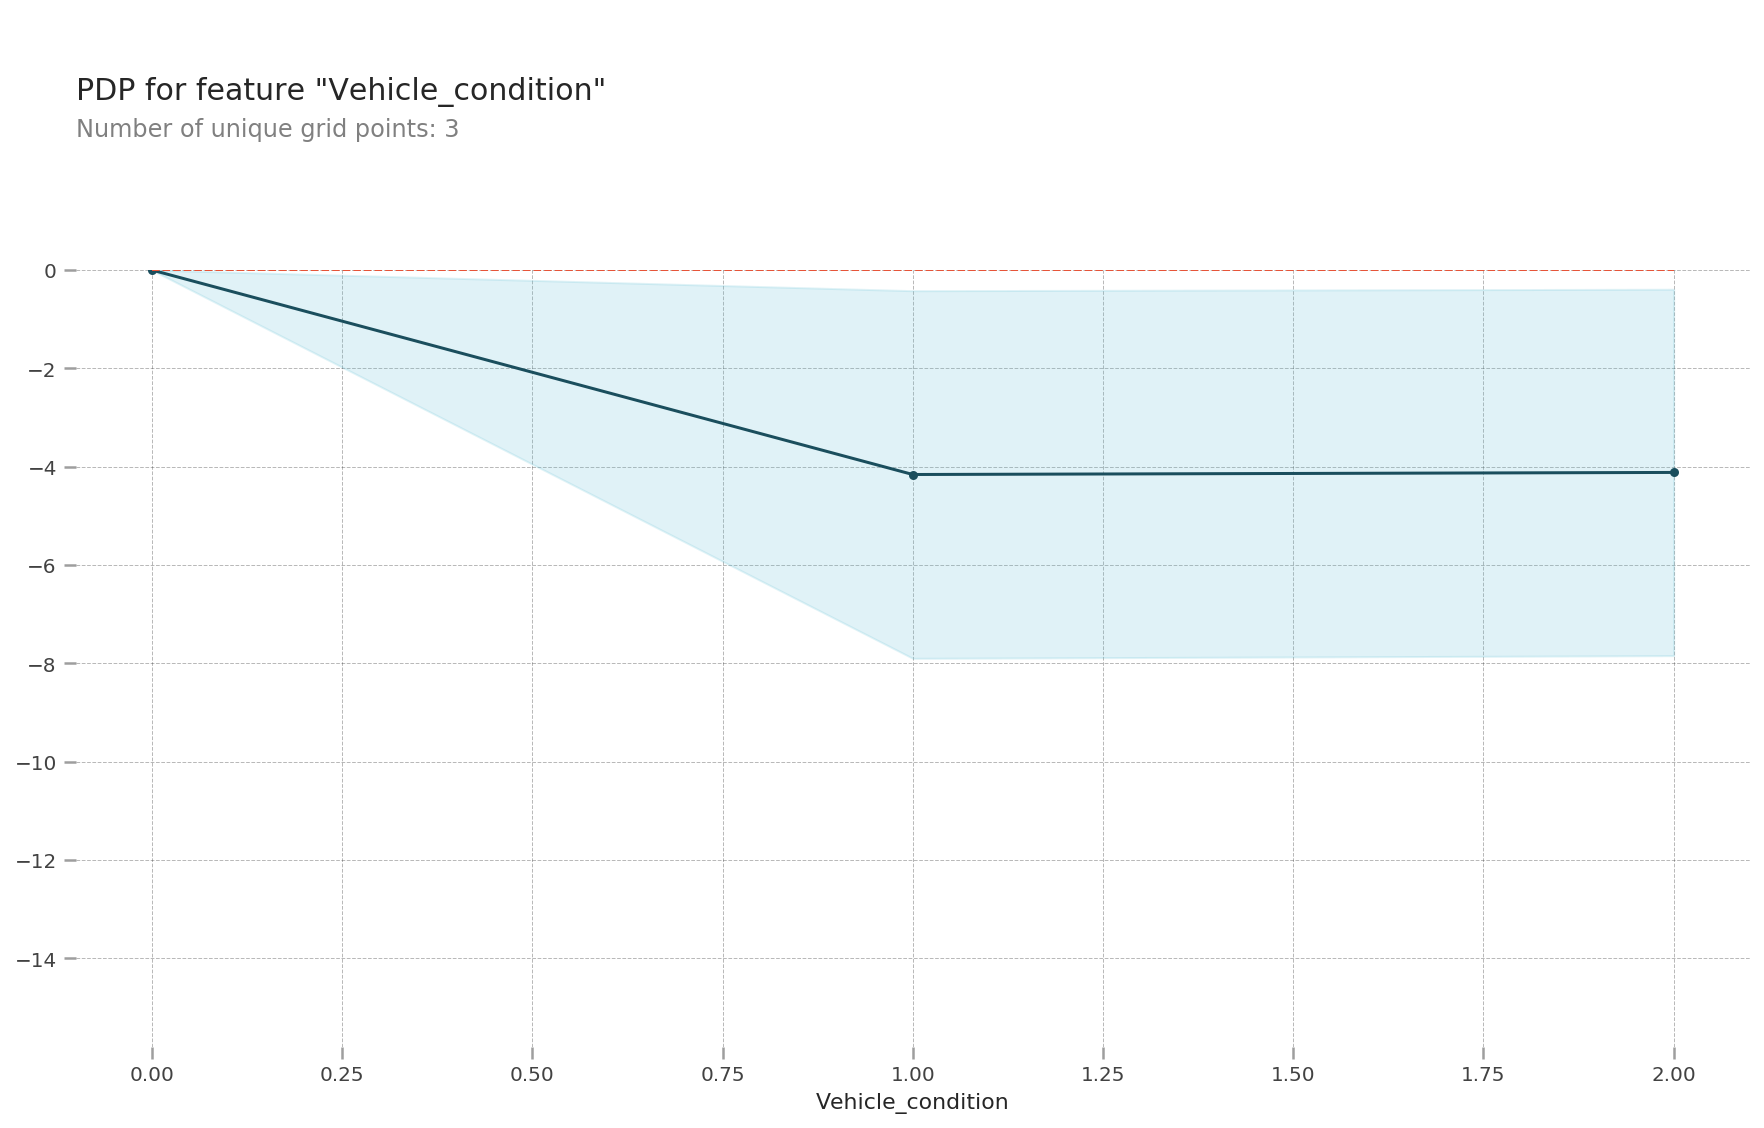

In [ ]:
pdp_check('Vehicle_condition')

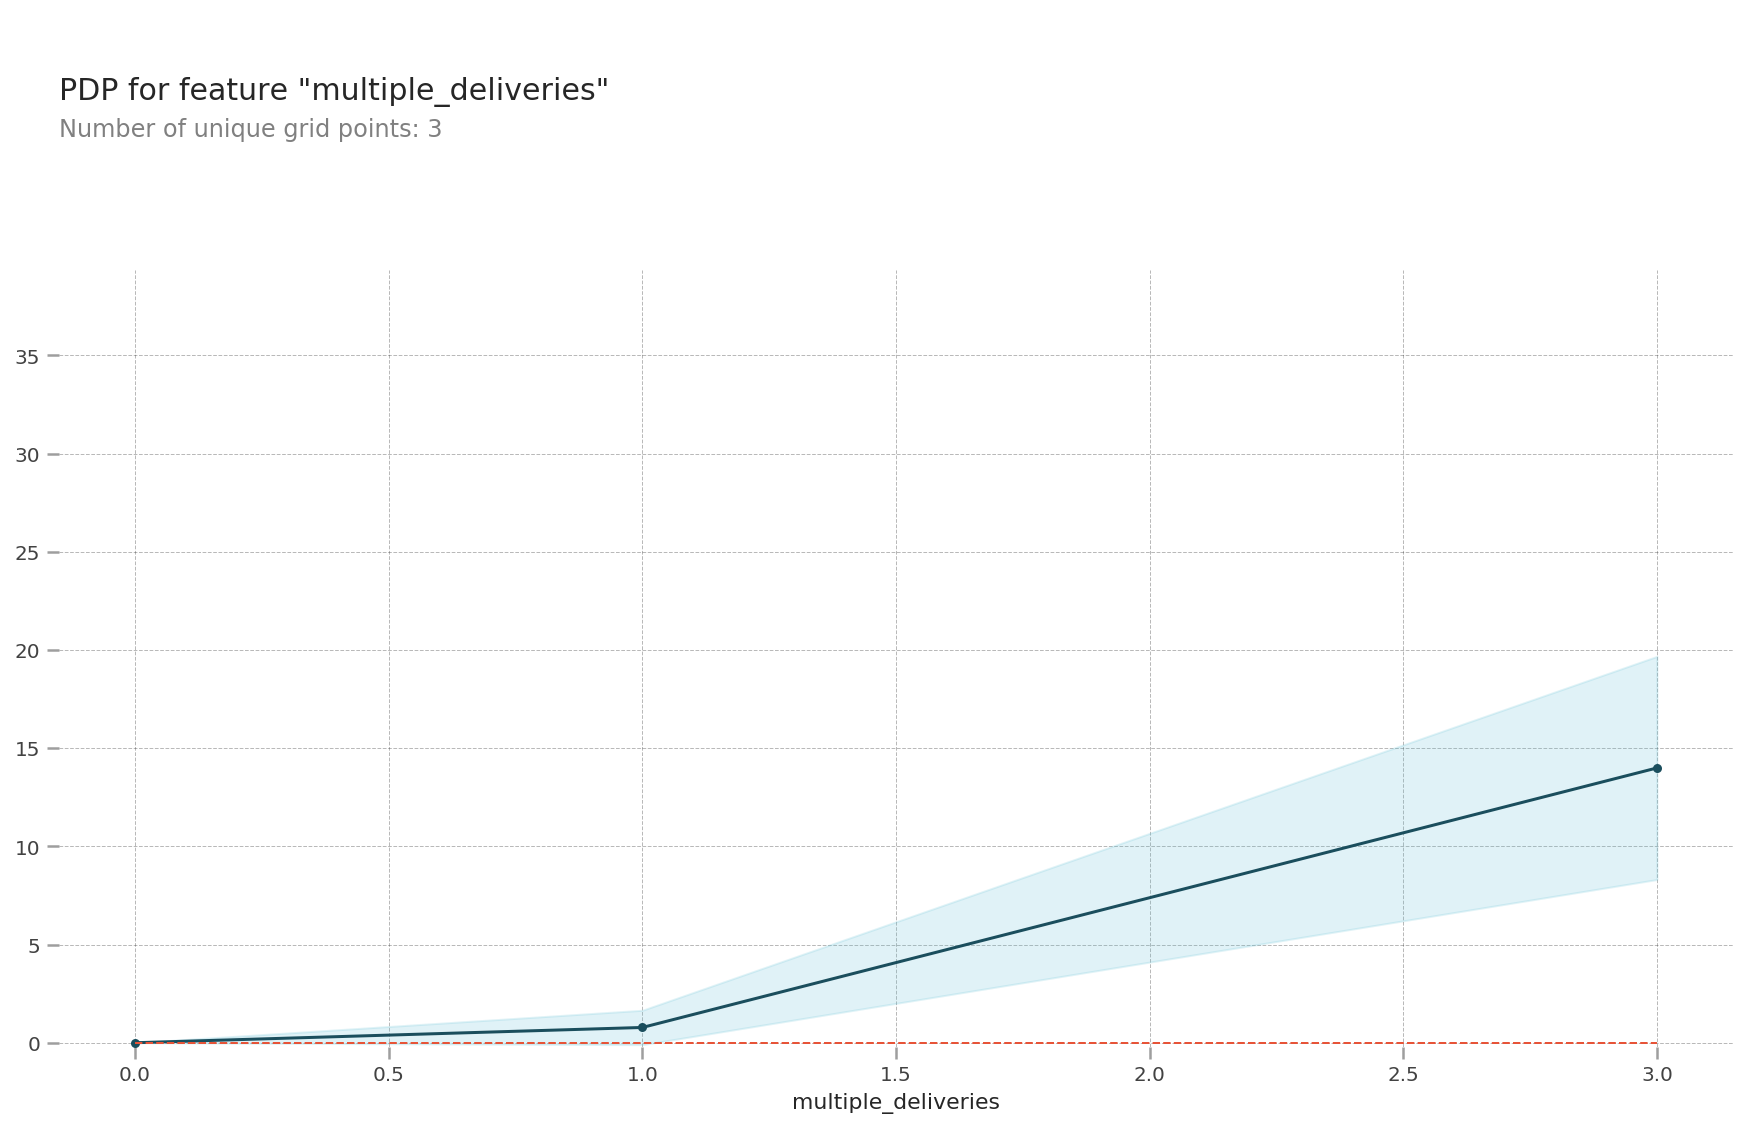

In [ ]:
pdp_check('multiple_deliveries')

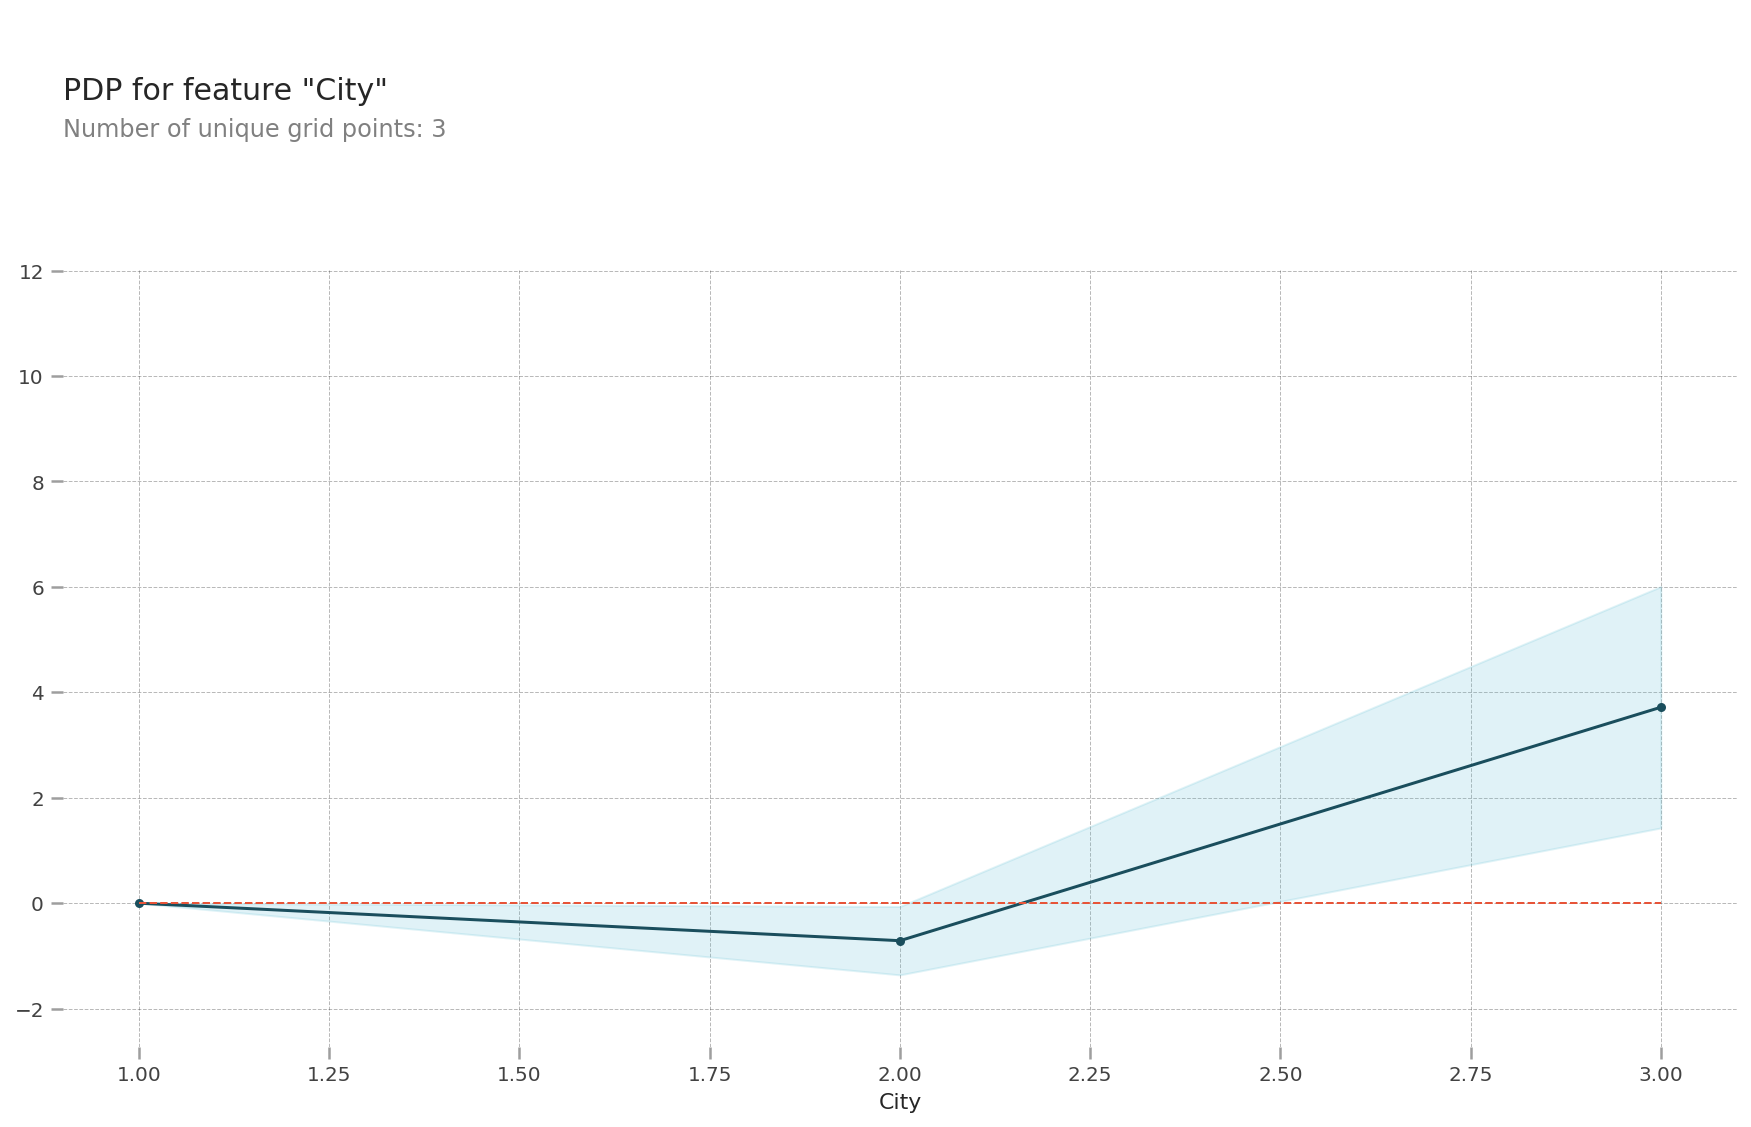

In [ ]:
pdp_check('City')

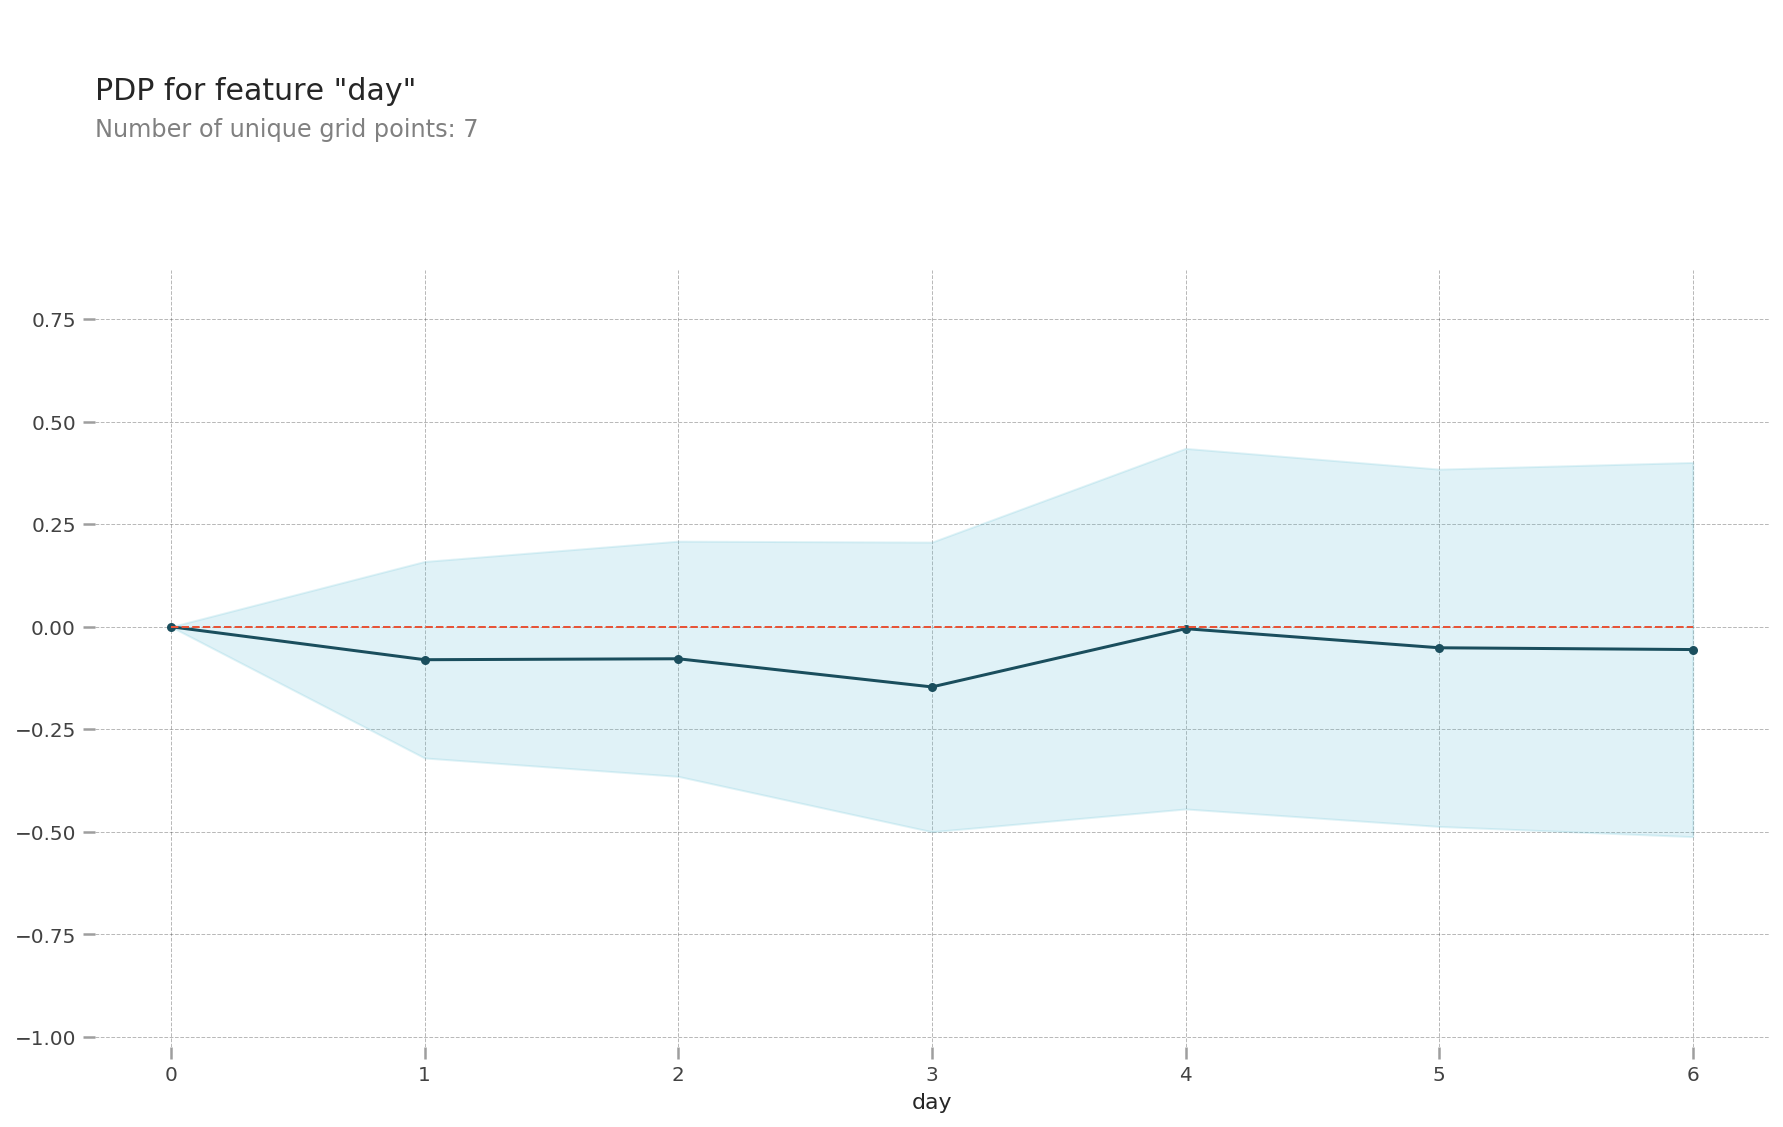

In [ ]:
pdp_check('day') # 목요일에 가장 빠른 배달이 가능함

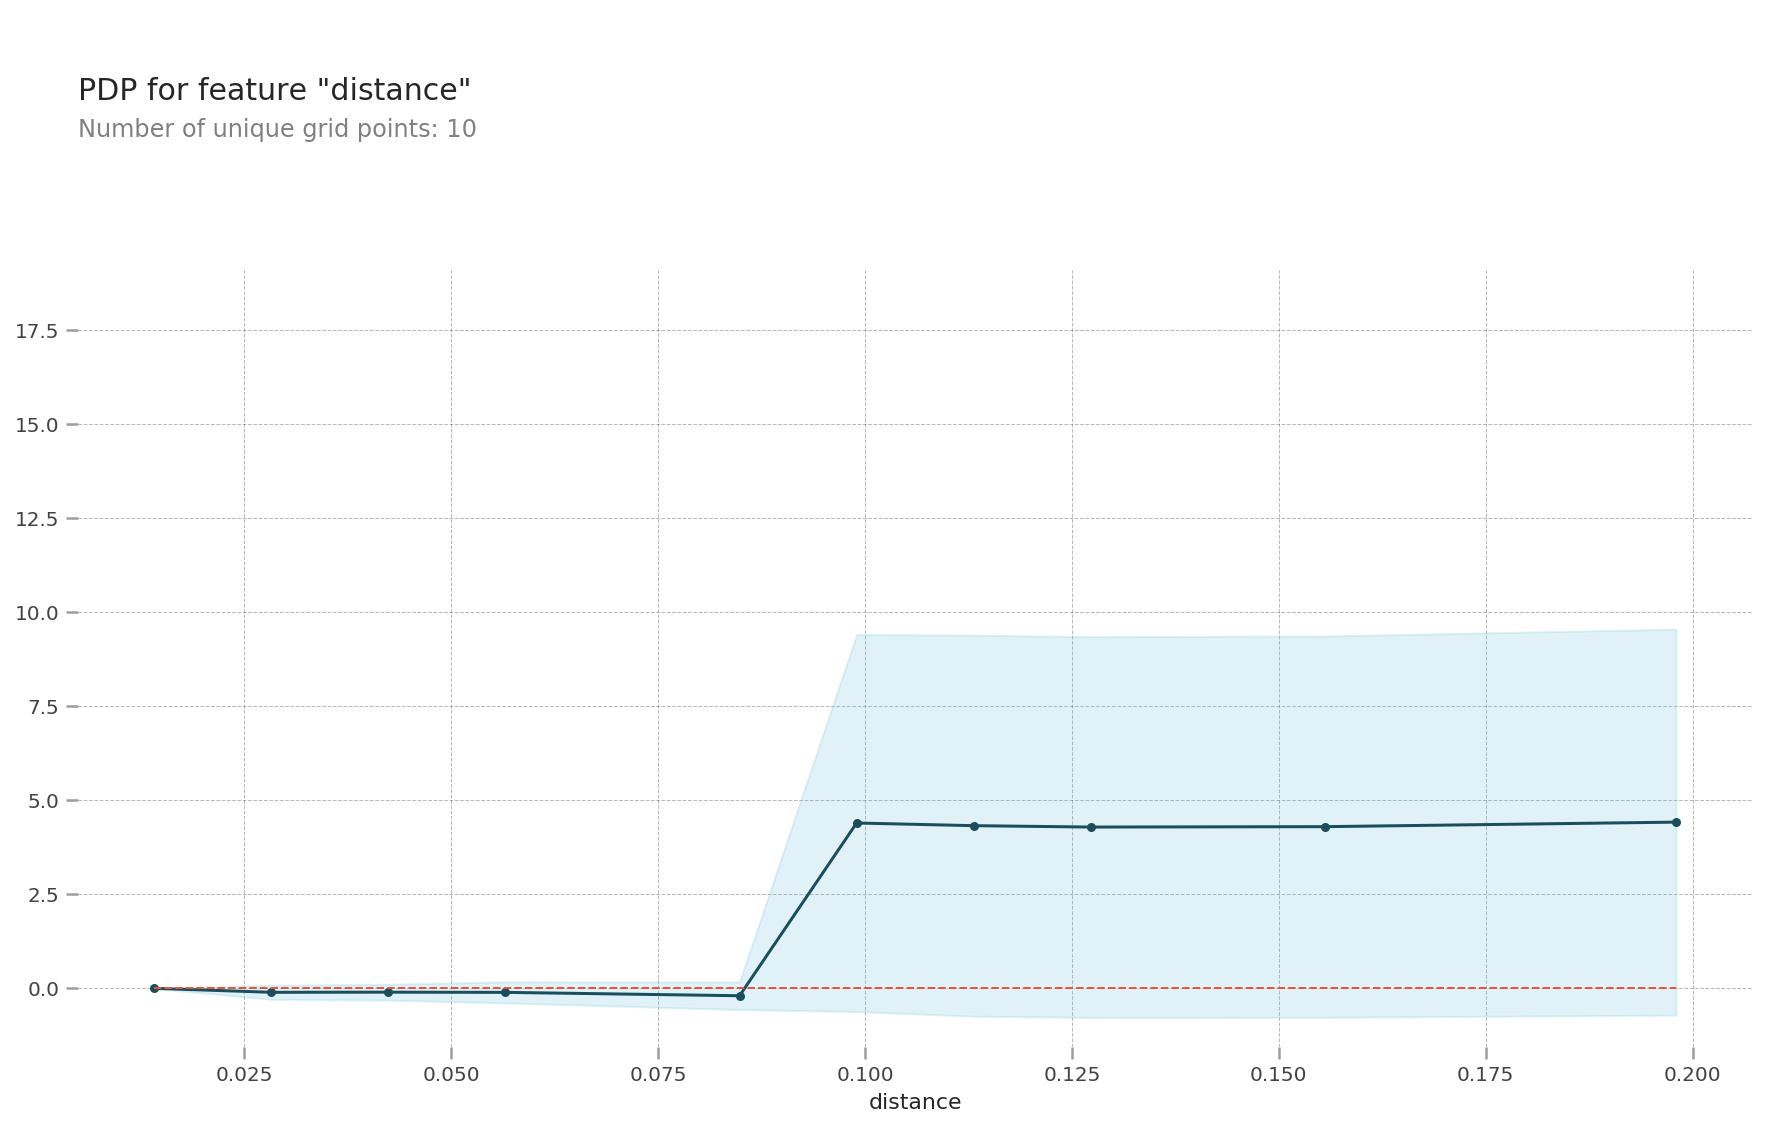

In [ ]:
pdp_check('distance')

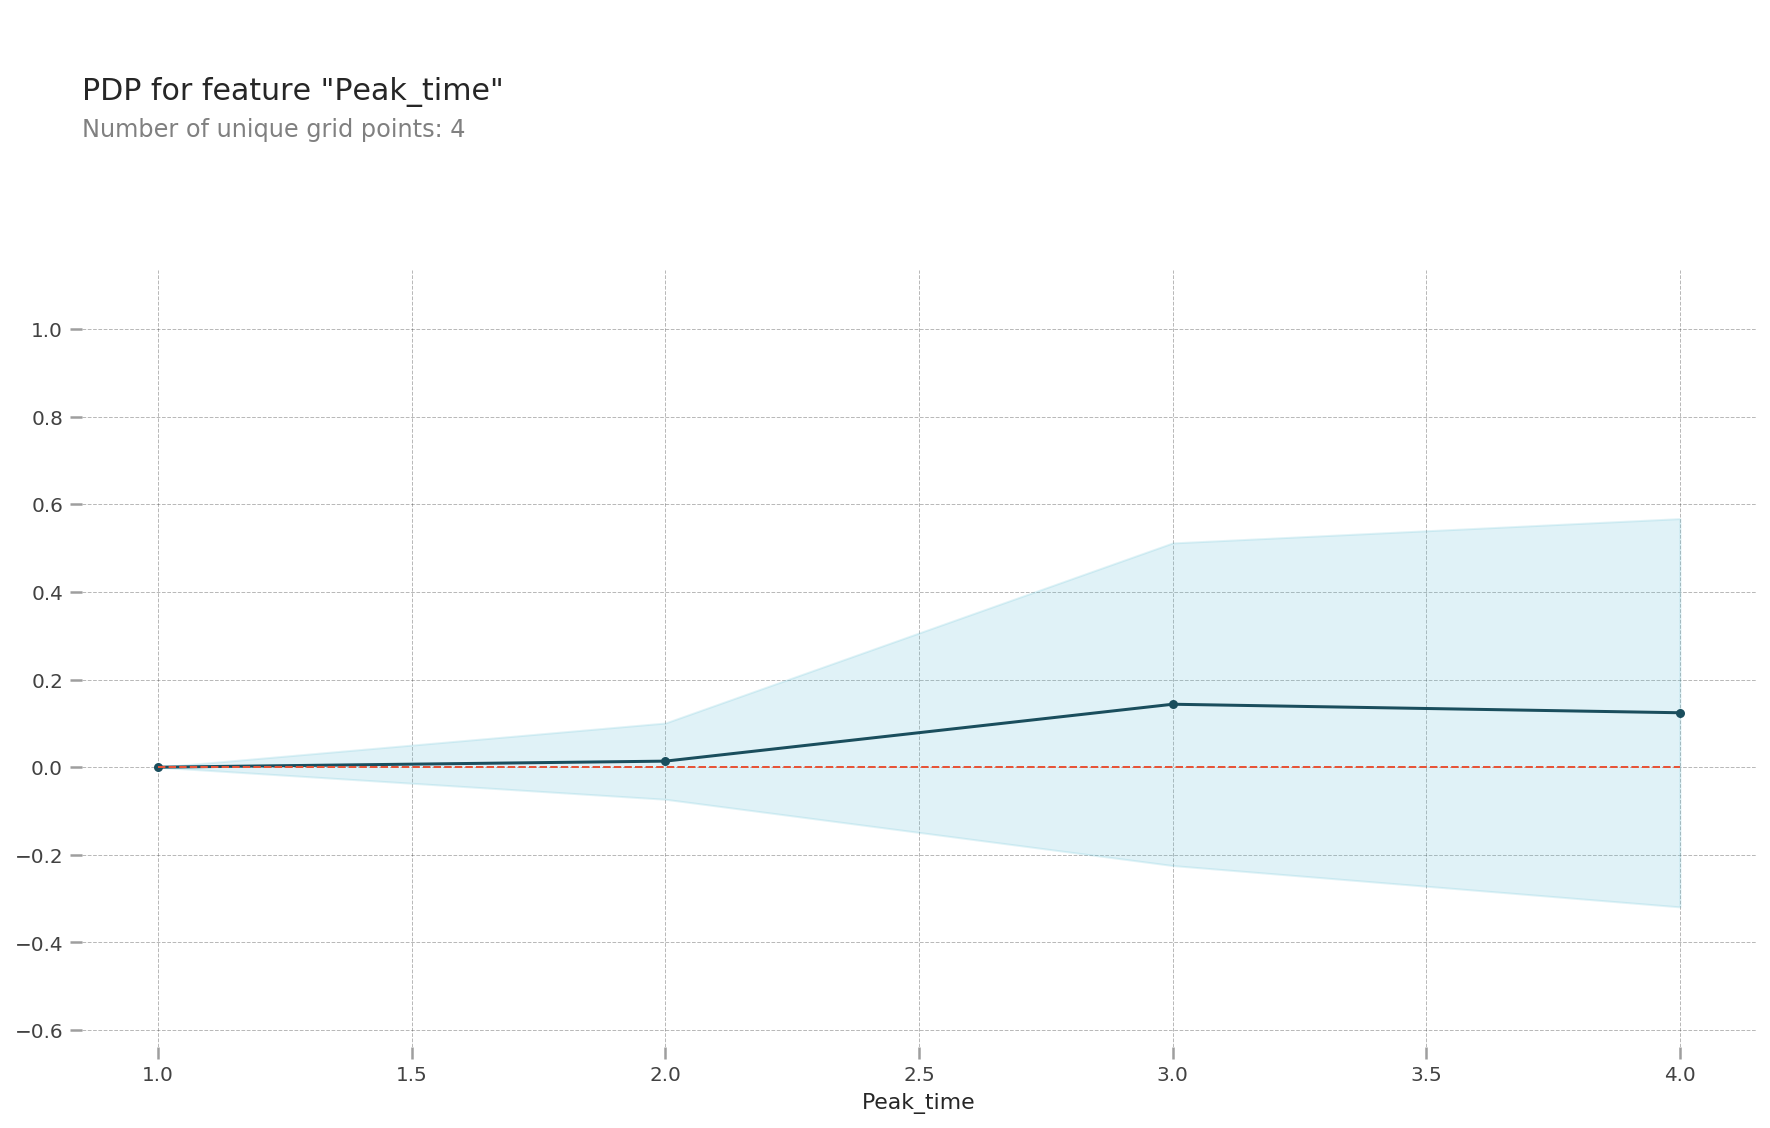

In [ ]:
pdp_check('Peak_time')

In [ ]:
!pip3 install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 11.3 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=66c669a13774ced1e7b7f125120218ca6e671354f0809cad26e1d07685498b75
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 2.3.10 requires scikit-learn==0.23.2, but you have scikit-learn 1.0.2 which i

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    automl.model,  # model
    scoring="neg_mean_squared_log_error",
    n_iter=10,
    random_state=42,
)

# 스코어를 다시 계산합니다.
permuter.fit(X_test, y_test)

PermutationImportance(estimator=<flaml.model.XGBoostSklearnEstimator object at 0x7fd50957c590>,
                      n_iter=10, random_state=42,
                      scoring='neg_mean_squared_log_error')

In [ ]:
# 특성별 score을 확인합니다.
feature_names = X_test.columns.tolist()
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names, 
)

Weight,Feature
0.0484 ± 0.0017,Weather
0.0419 ± 0.0010,Road_traffic_density
0.0308 ± 0.0014,distance
0.0252 ± 0.0018,Delivery_person_Ratings
0.0218 ± 0.0009,Vehicle_condition
0.0107 ± 0.0009,multiple_deliveries
0.0107 ± 0.0008,age_group_20s
0.0072 ± 0.0006,Delivery_person_Age
0.0009 ± 0.0001,H1
0.0009 ± 0.0002,Festival


In [ ]:
# 위 초록색의 변수들이 배달시간예측을 하기 위해 중요한 변수로 작용된다.

In [ ]:
# 배달시간을 오래걸리게하는 변수들 : Weather, Road_traffic_density, multiple_deliveries, distance
# 배달시간에 도움을 주는 변수들 : Delivery_person_Ratings, Vehicle_condition

In [ ]:
# 릿지cv와 라쏘cv, 다항회귀도 사용해보고 싶었으나 코랩 런타임 오류로 인해 못함
# randomCV도 써보고 싶었으나 자꾸 런타임 오류가 발생... 결국 해결하지 못함
# test 데이터는 예측변수가 주어지지 않은 데이터였기 때문에 활용하지 못함 -> 캐글 제출용